## Persiapan Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Baca dataset
df = pd.read_csv("dataset.csv")

# Tampilkan dataset
df.head()

,Recency,Frequency,Monetary
0,650,2,230467
1,789,1,115035
2,726,1,109598
3,663,1,112147
4,770,1,111744


In [3]:
# Buat objek MinMaxScaler untuk menormalisasikan nilai pada dataset
mms = MinMaxScaler()

# Aplikasikan (Fit) variabel `df` untuk dihasilkan (Transform) ke variabel `df_scaled` 
df_scaled = mms.fit_transform(df)

# Ubah bentuk array df_scaled menjadi Dataframe
df_scaled = pd.DataFrame(df_scaled, columns=['Recency', 'Frequency', 'Monetary'])

# Tampilkan
df_scaled

,Recency,Frequency,Monetary
0,0.012346,0.045455,0.088999
1,0.870370,0.000000,0.044423
2,0.481481,0.000000,0.042323
3,0.092593,0.000000,0.043308
4,0.753086,0.000000,0.043152
...,...,...,...
2233,0.154321,0.000000,0.043308
2234,0.617284,0.000000,0.071863
2235,0.259259,0.000000,0.043308
2236,0.197531,0.000000,0.086615


In [5]:
# Untuk eksperimen, buat variabel baru tanpa 1 outlier
df_scaled_no_outlier = mms.fit_transform(df.drop(index=1328))

# Ubah bentuk array df_scaled_no_outlier menjadi Dataframe
df_scaled_no_outlier = pd.DataFrame(df_scaled_no_outlier, columns=['Recency', 'Frequency', 'Monetary'])

## Fungsi-Fungsi

In [4]:
# Fungsi Utama: Kustom K-Medoids
def custom_kmedoids(data, medoids, distance_func):
  """
  Performs k-medoids clustering with custom medoids and distance function.

  Args:
      data: A pandas dataframe containing the data points.
      medoids: A list of data points representing the initial medoids.
      distance_func: A function that calculates the distance between two data points.

  Returns:
      A list containing cluster labels for each data point.
  """
  # Ambil baris data (data points) dari variabel `data` yang diberikan
  data_points = data.values
  # Ambil panjang medoids yang diberikan
  n_clusters = len(medoids)

  # Inisialisasi cluster dengan jumlah medoids
  clusters = [[] for _ in range(n_clusters)]
  # Ambil tiap indeks serta nilai data dalam keseluruhan dataset
  for i, point in enumerate(data_points):
    # Gunakan fungsi Distance yang diberikan agar mengukur titik data & titik medoid pada tiap medoid 
    # sehingga menghasilkan jarak antara data dan medoid
    distances = [distance_func(point, medoid) for medoid in medoids]
    # Ambil indeks baris data berdasarkan jarak terkecilnya dalam variabel `distances`
    cluster_label = distances.index(min(distances))
    # Masukkan indeks baris data tersebut ke dalam list cluster pada indeks data ke-i
    clusters[cluster_label].append(i)

  # Iterasi sampai data konvergen
  converged = False
  while not converged:
    converged = True
    new_clusters = [[] for _ in range(n_clusters)]
    for cluster_label, points in enumerate(clusters):
      for point_index in points:
        distances = [distance_func(data_points[point_index], medoid) for medoid in medoids]
        new_cluster_label = distances.index(min(distances))
        if new_cluster_label != cluster_label:
          converged = False
        new_clusters[new_cluster_label].append(point_index)
    clusters = new_clusters

  # Berikan label pada tiap titik data
  labels = [-1] * len(data_points)
  for i, cluster in enumerate(clusters):
    for point_index in cluster:
      labels[point_index] = i

  return labels

# Definisikan tiga Distance Functions
def euclidean_distance(p1, p2):
  return np.linalg.norm(p1 - p2)

def manhattan_distance(p1, p2):
  return np.sum(np.abs(p1 - p2))

def chebyshev_distance(p1, p2):
  return np.max(np.abs(p1 - p2))


# Fungsi untuk membuat plotting cluster
def plot_clusters(data, labels, medoids, option, title, size, save=False):
  """
  Plots the data points with labels and medoids.

  Args:
      data: A pandas dataframe containing the data points.
      labels: A list containing cluster labels for each data point.
      medoids: A list of data points representing the medoids.
      option: A list of containing the data column option.
      title: The title for the plot.
      size: The size of the plot.
      save: (Optional) Whether to save the plot or not.
  """
  colors = plt.get_cmap('Set2')(labels)  # Gunakan colormap Set2 untuk warna cluster

  # Atur ukuran grafik menggunakan variabel `size`
  plt.figure(figsize=size)
  # Buat grafik titik data dengan warna berdasarkan cluster pada variabel `labels`
  plt.scatter(data[option[0]], data[option[1]], c=colors, alpha=0.5, label='Data')

  i = 0 # Angka untuk penamaan cluster
  medoid_colors1 = ['red', 'blue', 'orange', 'green', 'purple'] # Warna merah, biru, oranye, hijau, dan ungu
  # Buat titik setiap medoid
  for medoid in medoids:
    plt.scatter(medoid[option[2]], medoid[option[3]], 
                marker='*', s=120, alpha=0.75, c=medoid_colors1[i], label=f'C{i}')
    i += 1

  # Tambahkan informasi grafik beserta opsi untuk simpan
  plt.xlabel(option[0])
  plt.ylabel(option[1])
  plt.title(title)
  plt.legend()
  if save:
    plt.savefig("[{}-{}] - {}.png".format(option[0], option[1], title), bbox_inches='tight')
  plt.show()


# Fungsi Eksekusi 
def execute(data, medoids_list, options, size, output_plots=True, save_fig=False, output_labels=None):
  """
  Execute the algorithm on the data points with labels and medoids.

  Args:
      data: A pandas dataframe containing the data points.
      medoids_list: A list of data points representing the medoids.
      options: A list of column options for the plot function.
      size: The size of the figure for the plot.
      output_plots: (Optional) Whether to output the plots.
      save_fig: (Optional) Whether to save every plot, `output_plots` must be `True`.
      output_labels: (Optional) An empty list to save the produced labels.
  """
  # Eksekusi dari cluster = 2 hingga cluster = 5
  for n_clusters in range(2, 6):
    print(f"Clustering with {n_clusters} clusters:")
    # Kalkulasi titik data cluster pada N clusters tiap Distance
    for distance_func in [euclidean_distance, manhattan_distance, chebyshev_distance]:
      # Fungsi `custom_kmedoids` untuk menghasilkan labels tiap N clusters
      labels = custom_kmedoids(data.copy(), medoids_list[:n_clusters], distance_func)
      # Simpan nama dari fungsi
      distance_name = distance_func.__name__.replace("_", " ")
      # Tampilkan proses 
      print(f"Completed {distance_name}")
      # Jika output_labels diberikan, masukkan labels ke dalamnya untuk diproses selanjutnya
      if type(output_labels) == list:
        output_labels.append(labels)
      # Jika output_plots bernilai True, maka tampilkan plot tiap opsi dengan pilihan distance pada kluster
      if output_plots:
        for opt in options:
            plot_clusters(data.copy(), labels, medoids_list[:n_clusters],  
                          opt, f"{distance_name} - {n_clusters} clusters", size, save_fig)

In [5]:
# Sebutkan medoid untuk cluster indeks 0 hingga 4 (kluster pertama hingga kelima)
medoids = [
  [0.938, 0.000, 0.046], #C0
  [0.093, 0.000, 0.043], #C1
  [0.617, 0.000, 0.072], #C2
  [0.198, 0.000, 0.087], #C3
  [0.432, 0.000, 0.050]  #C4
]

# Opsi untuk tampilan grafik
opsi1 = ["Recency", "Frequency", 0, 1]
opsi2 = ["Recency", "Monetary", 0, 2]
opsi3 = ["Frequency", "Monetary", 1, 2]

# Buat tempat penyimpanan untuk hasil klustering
list_of_labels = []

## Eksekusi Dataset dengan 2 hingga 5 kluster medoid menggunakan Euclidean, Manhattan, dan Chebyshev

Clustering with 2 clusters:
Completed euclidean distance


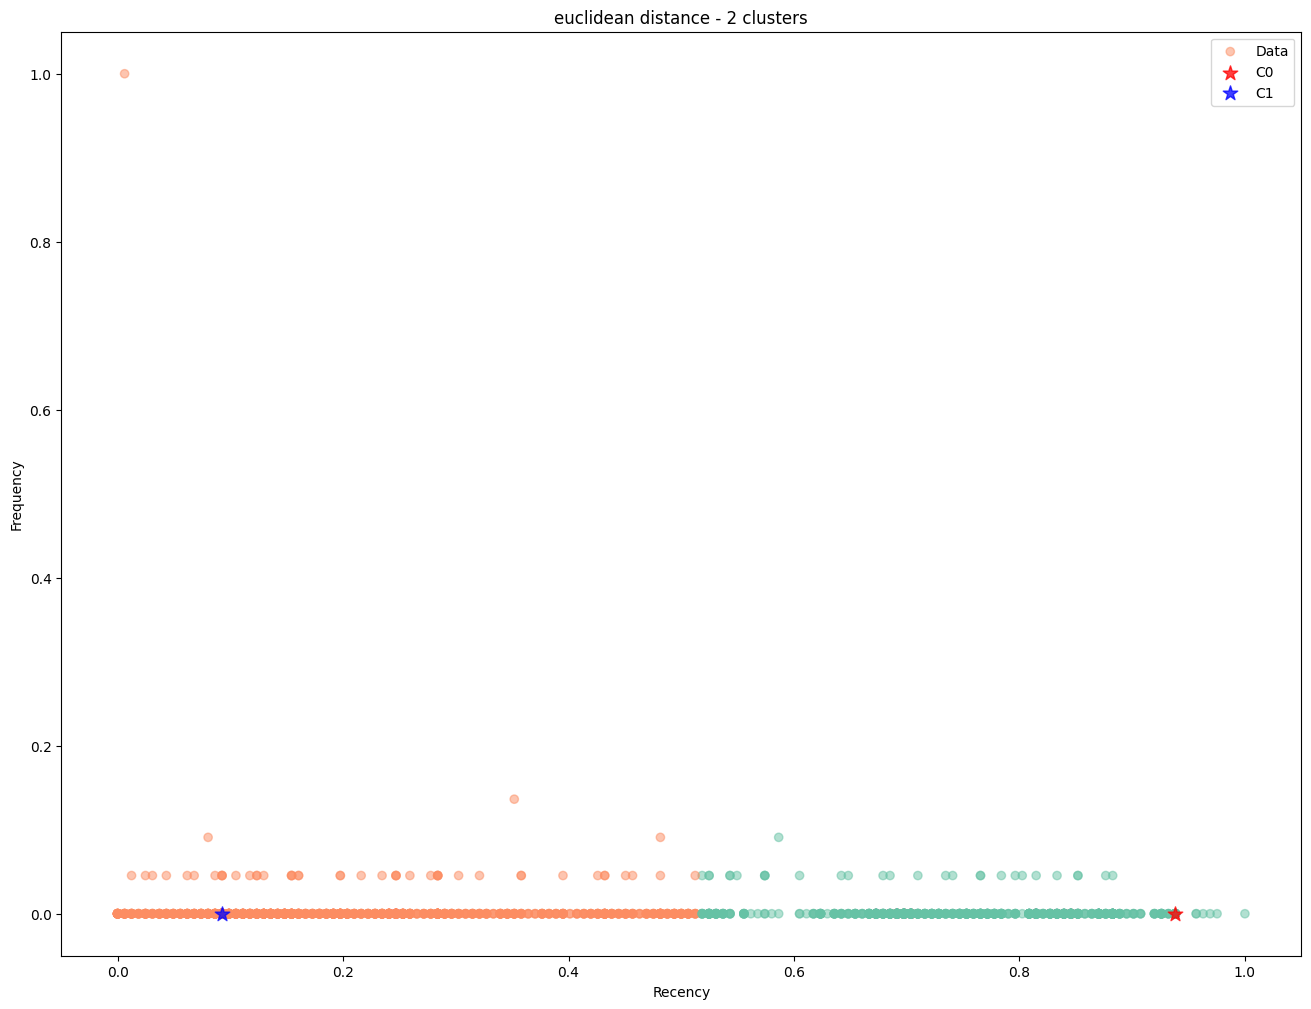

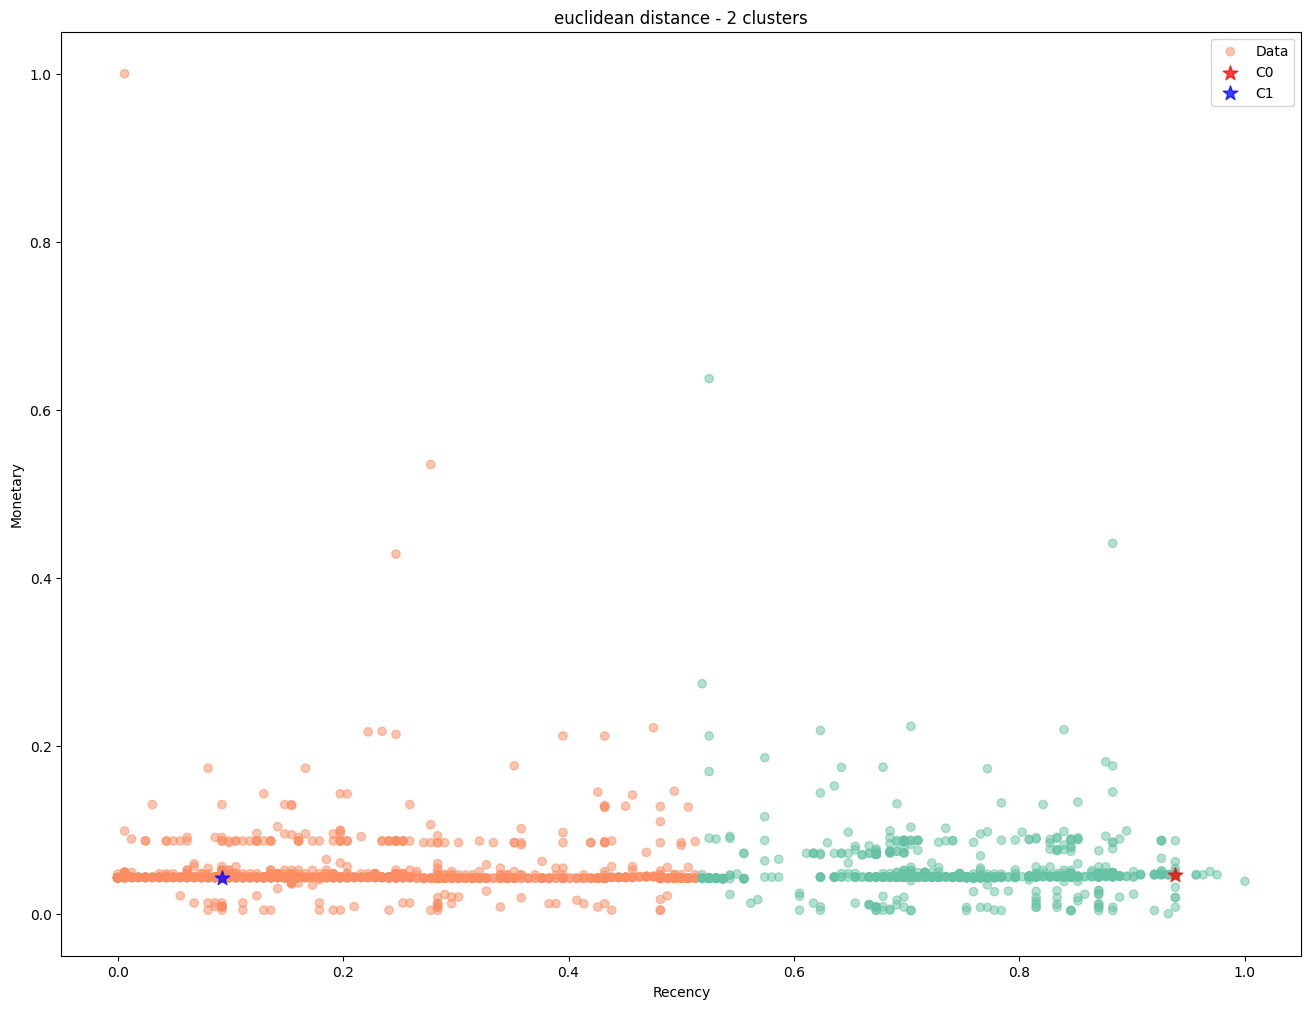

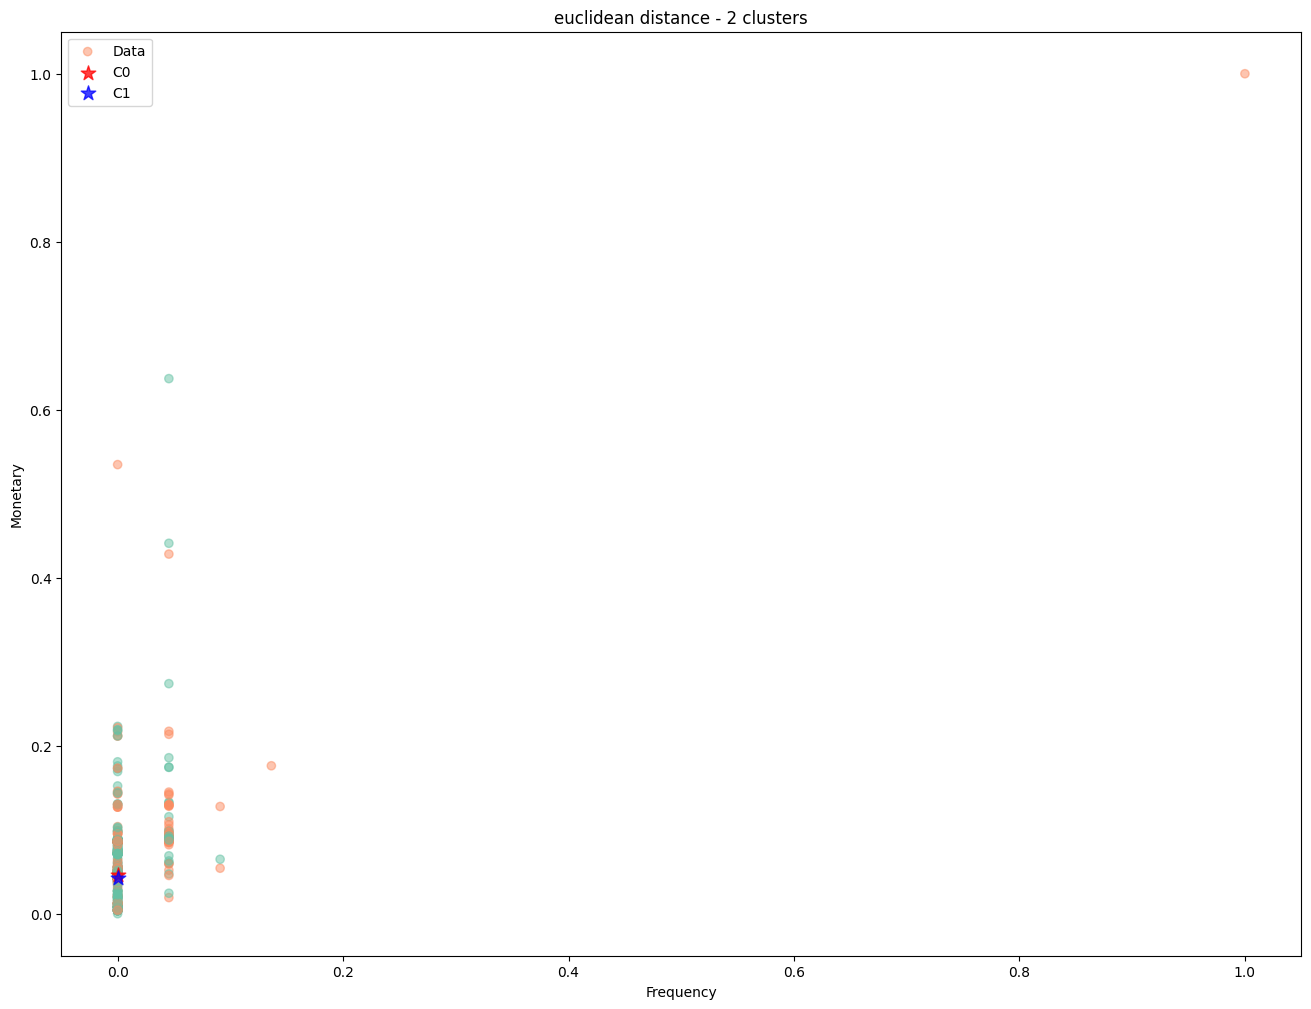

Completed manhattan distance


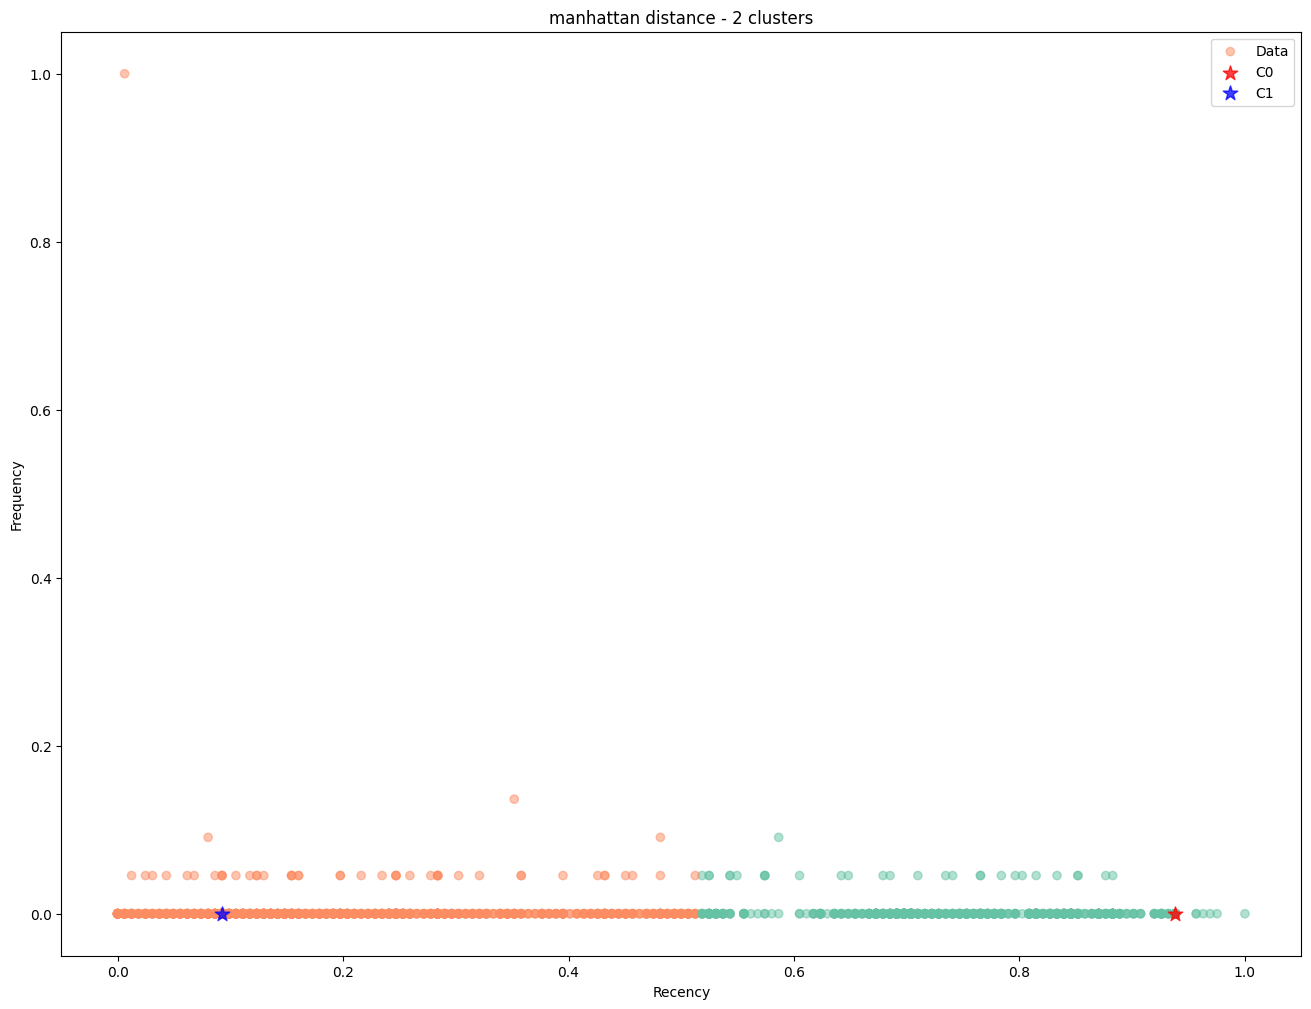

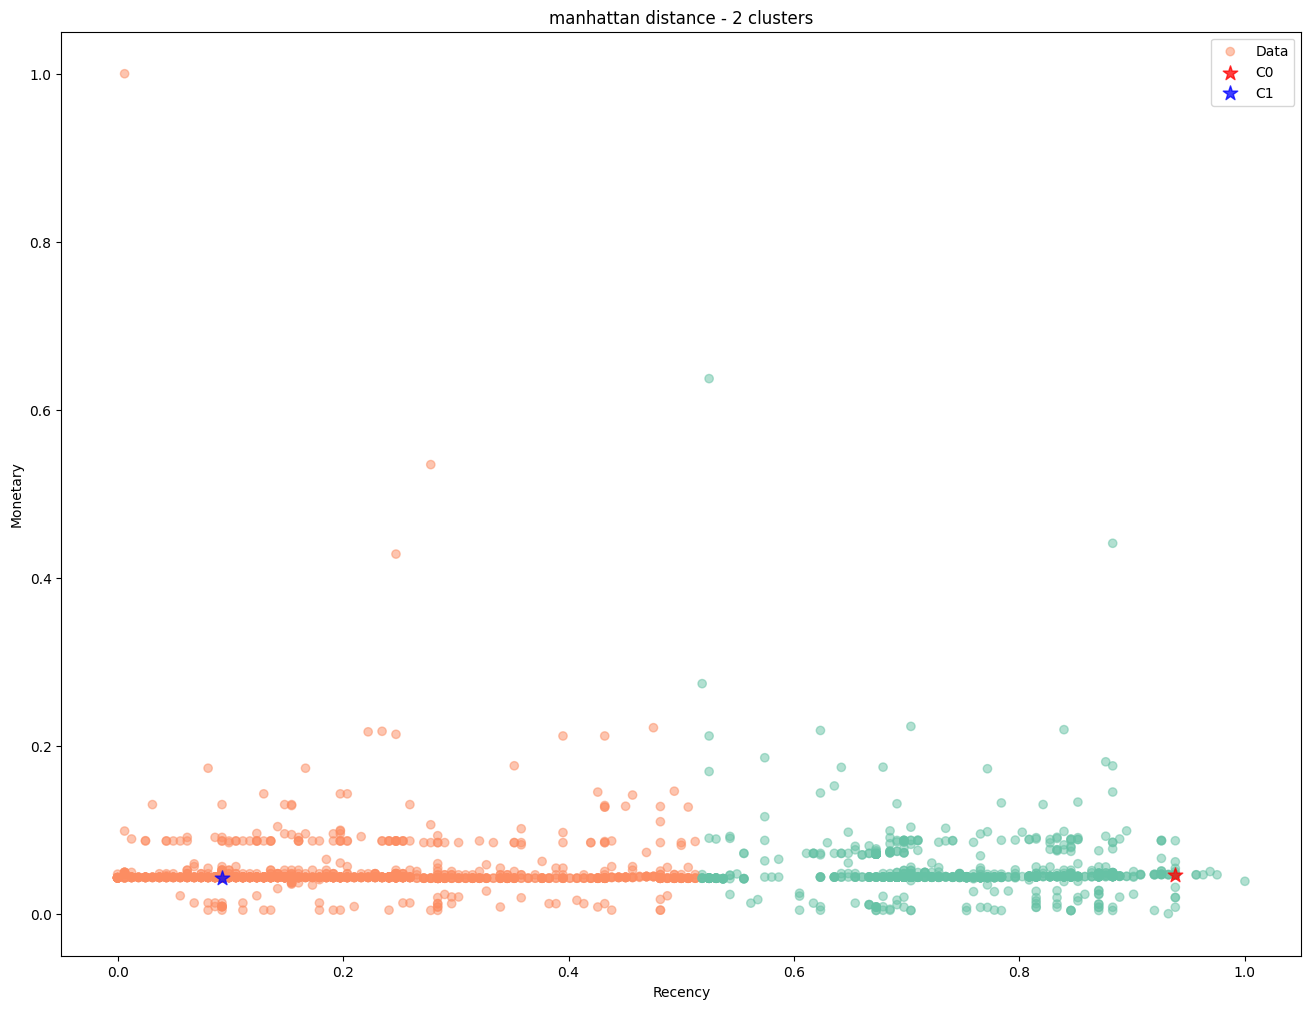

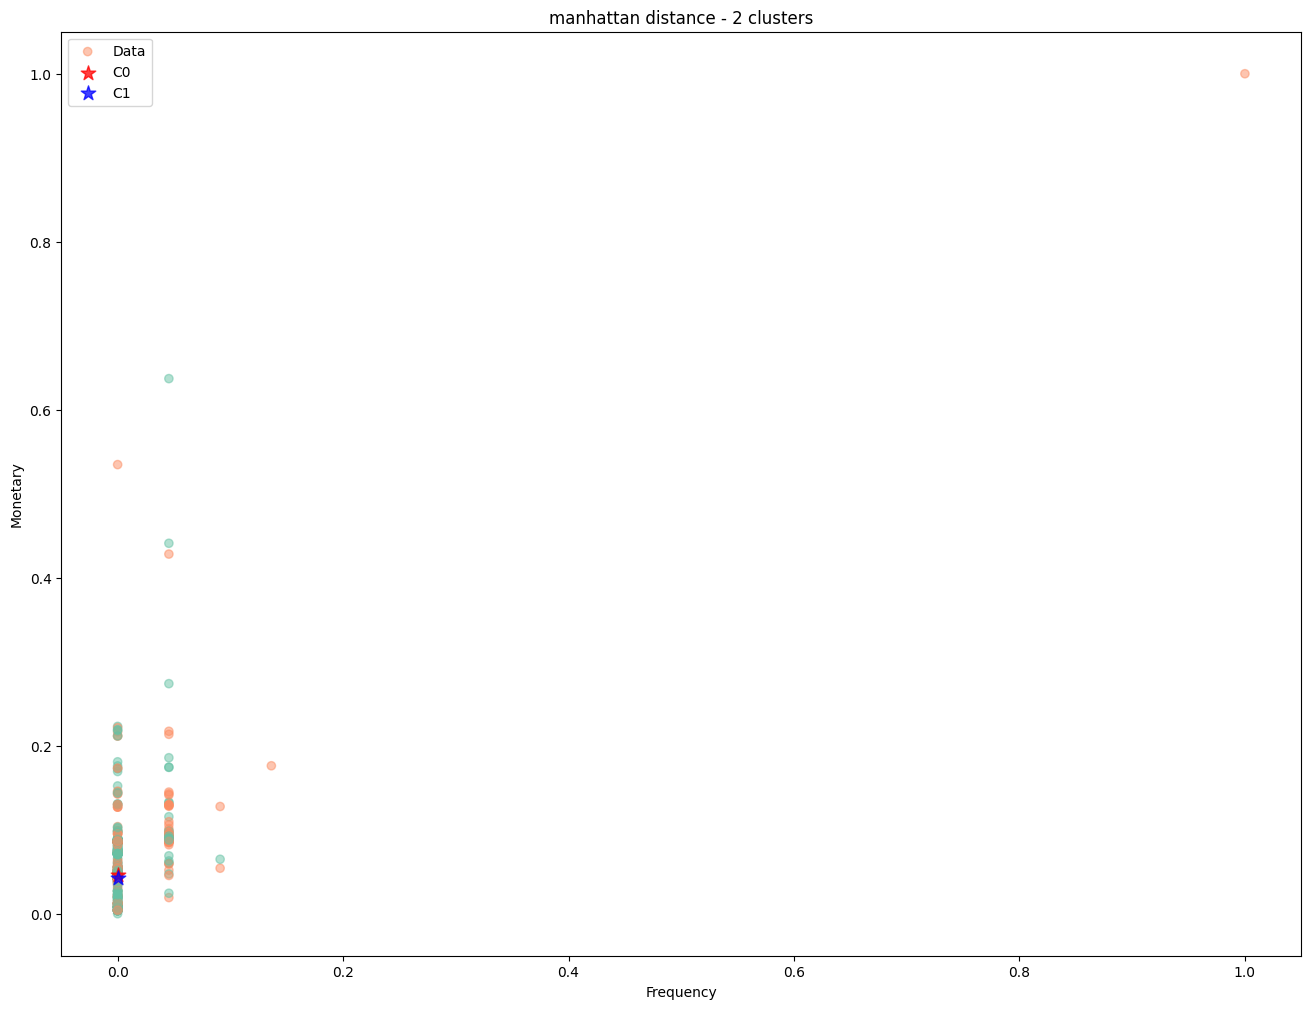

Completed chebyshev distance


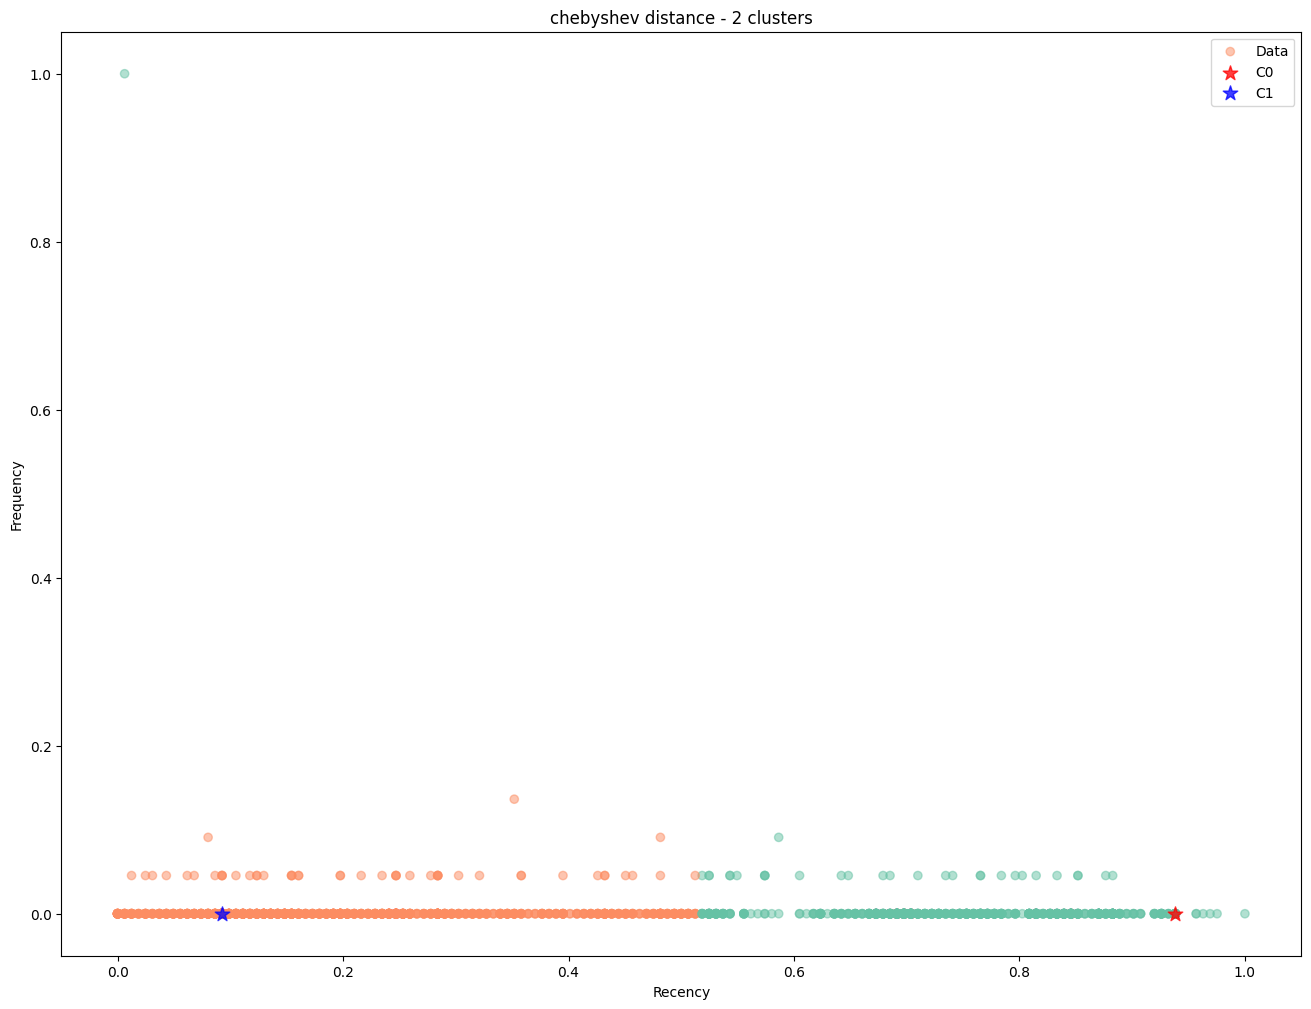

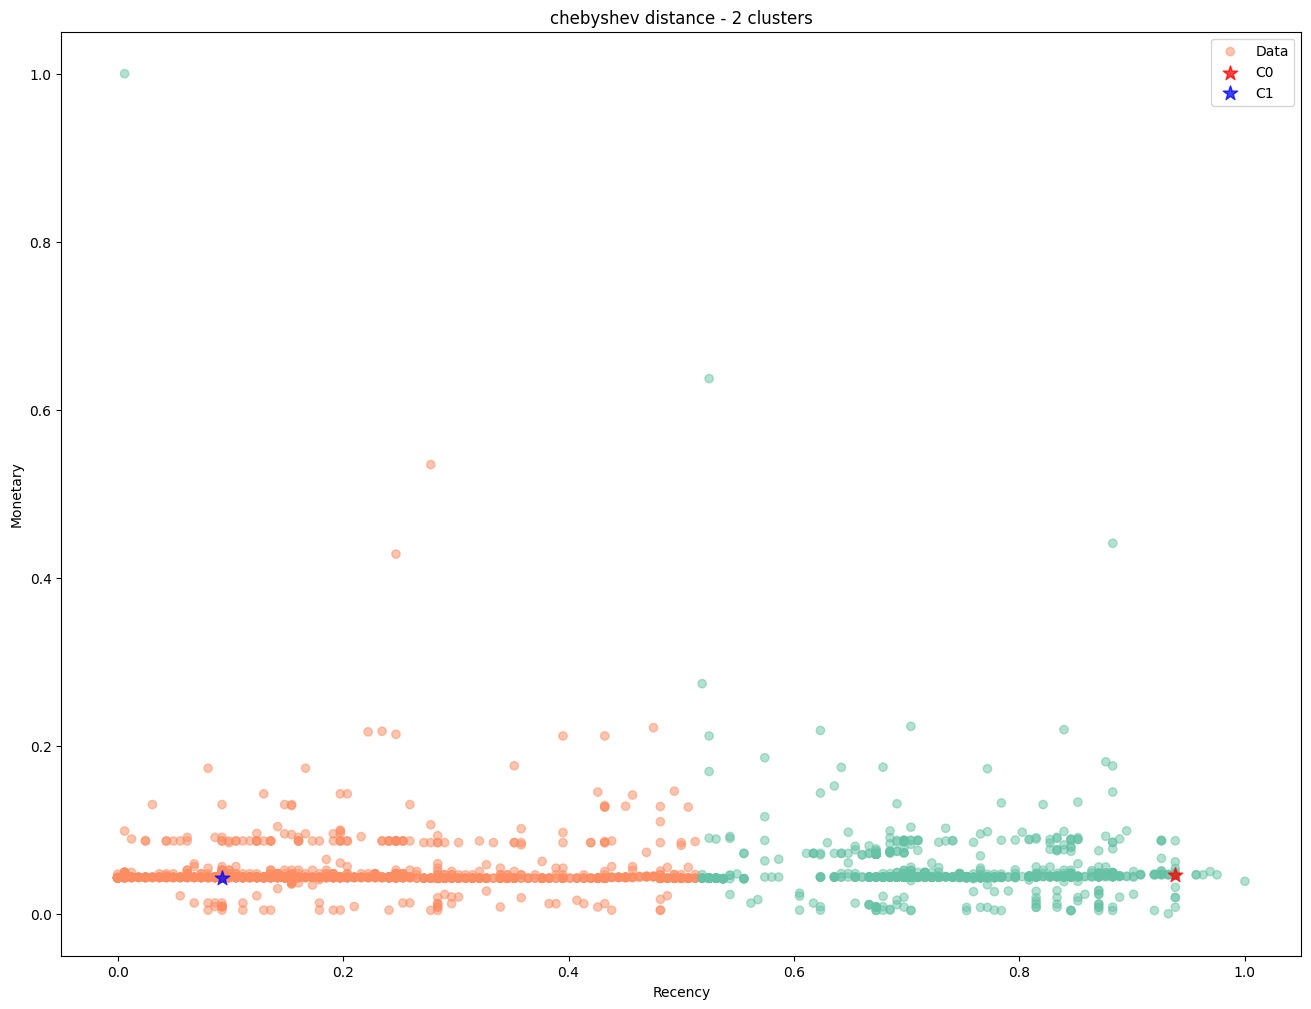

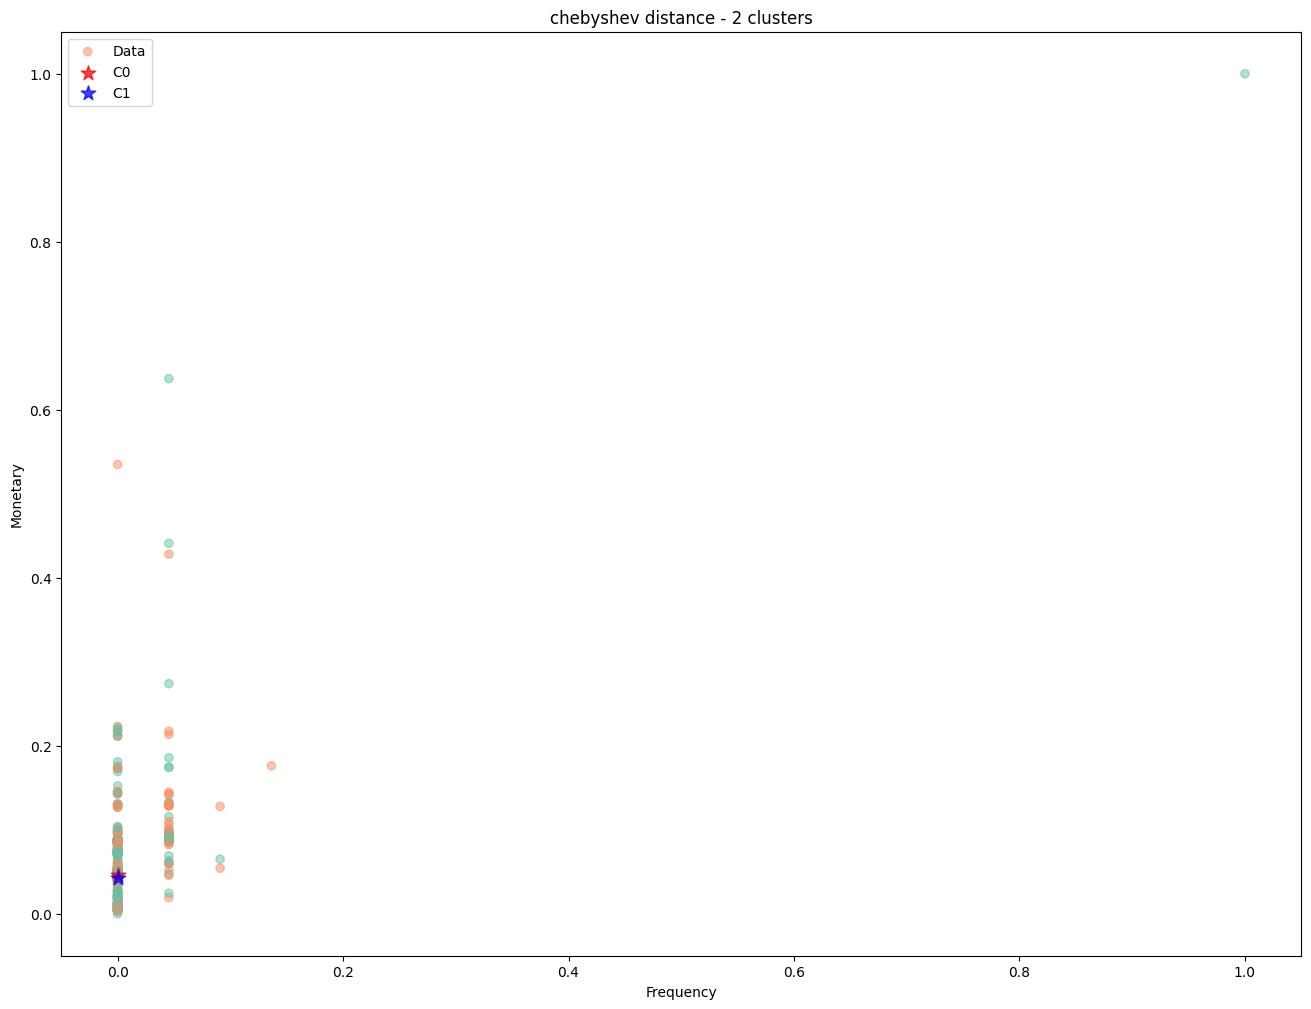

Clustering with 3 clusters:
Completed euclidean distance


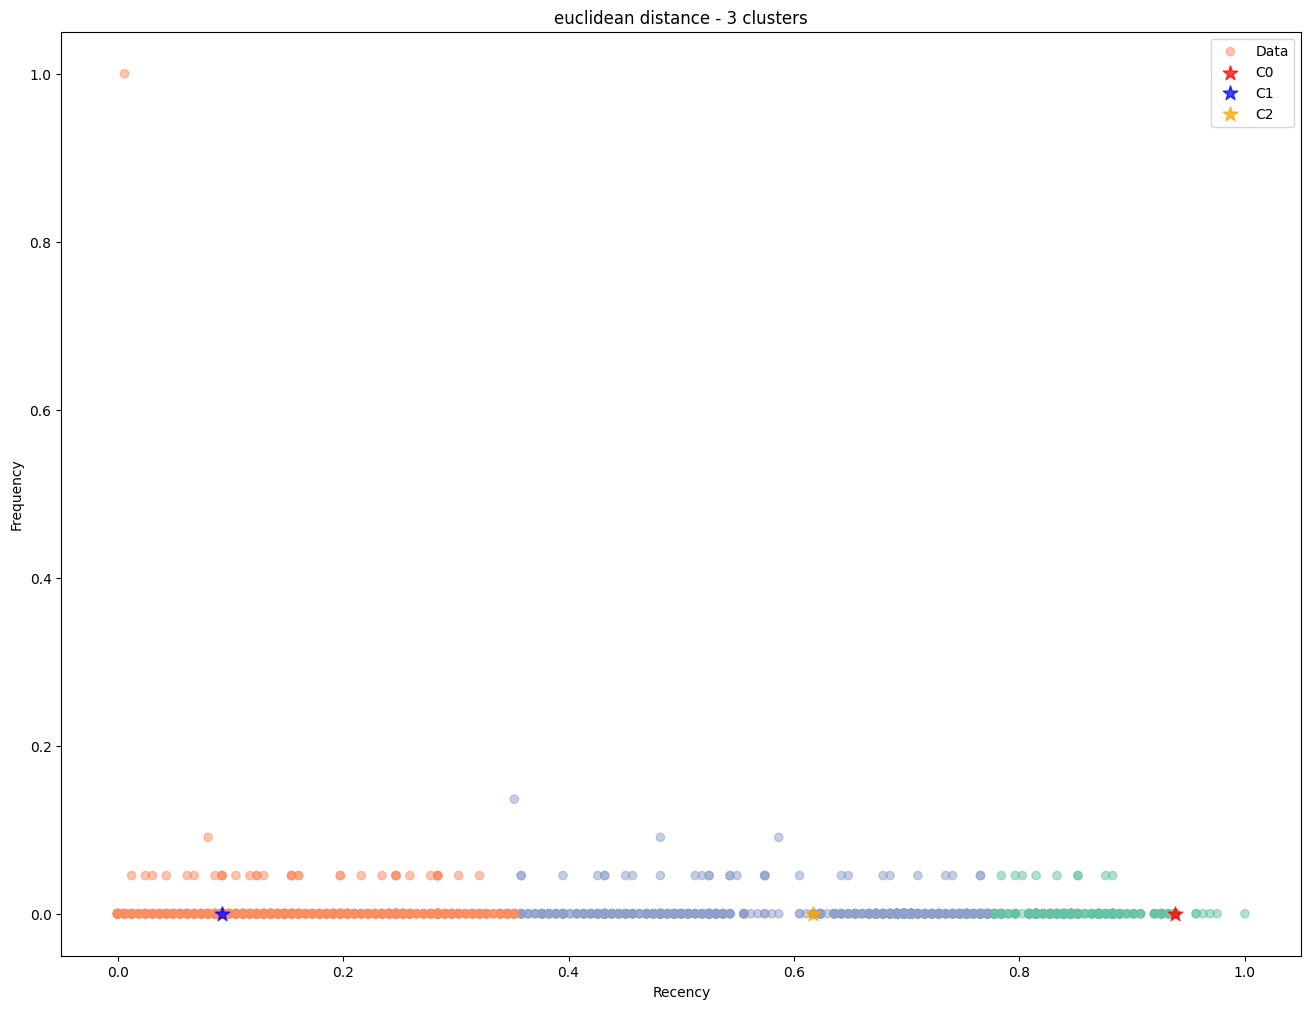

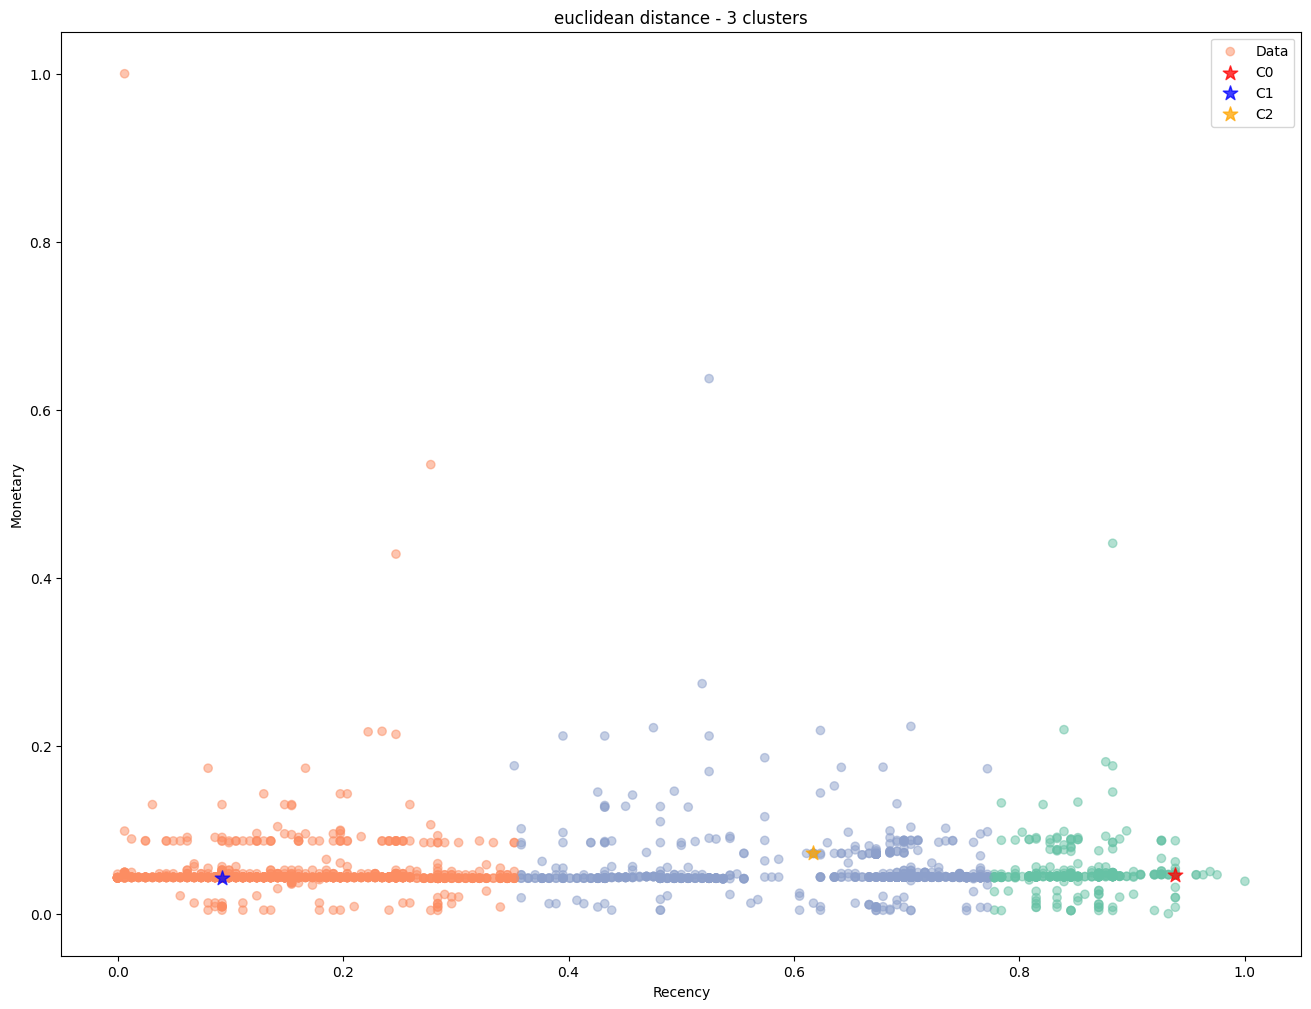

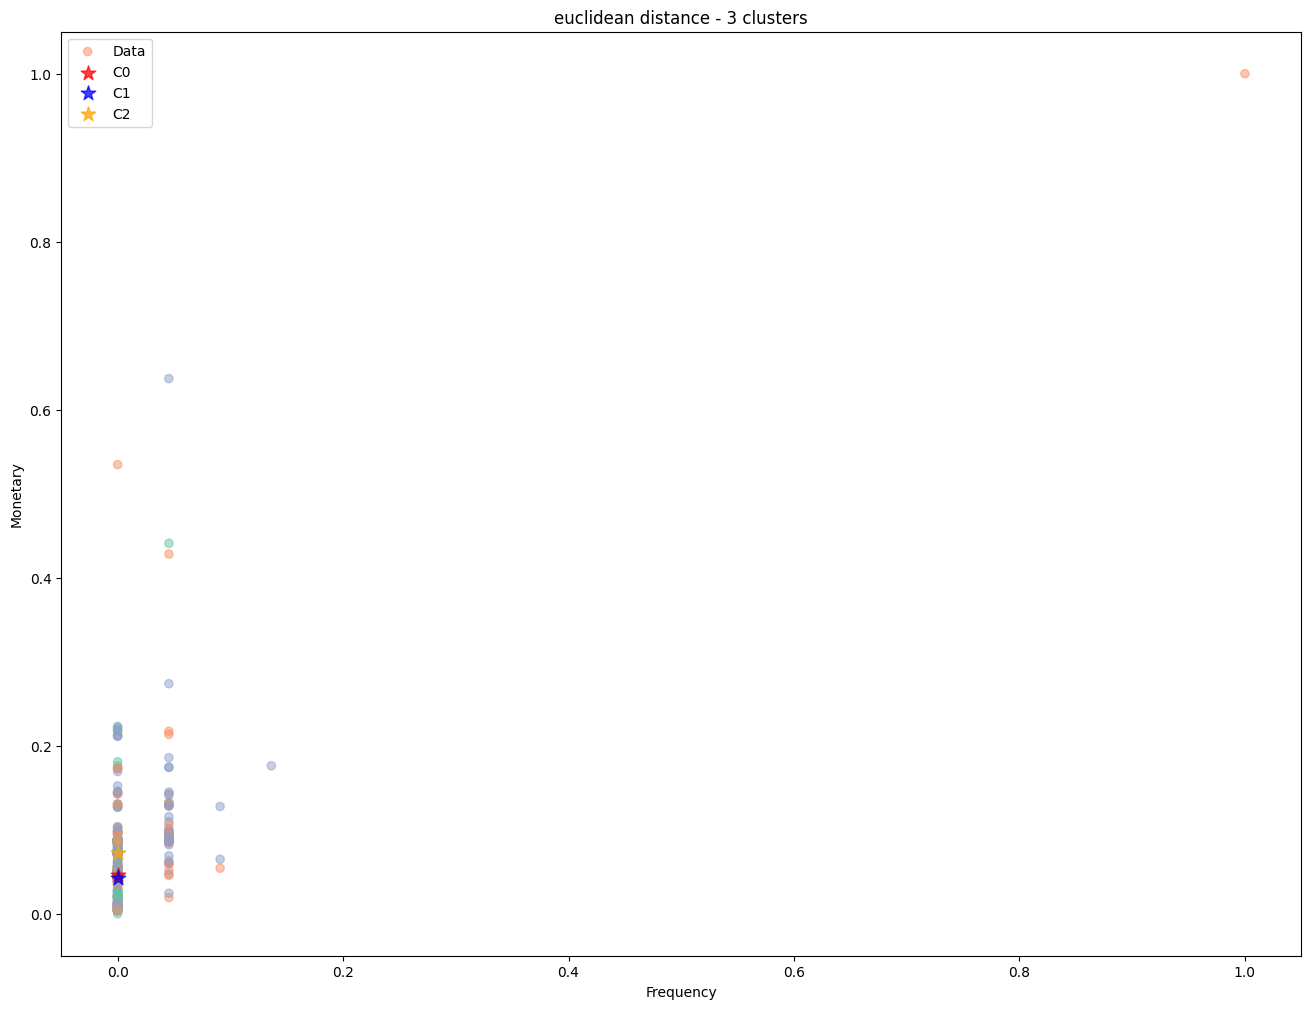

Completed manhattan distance


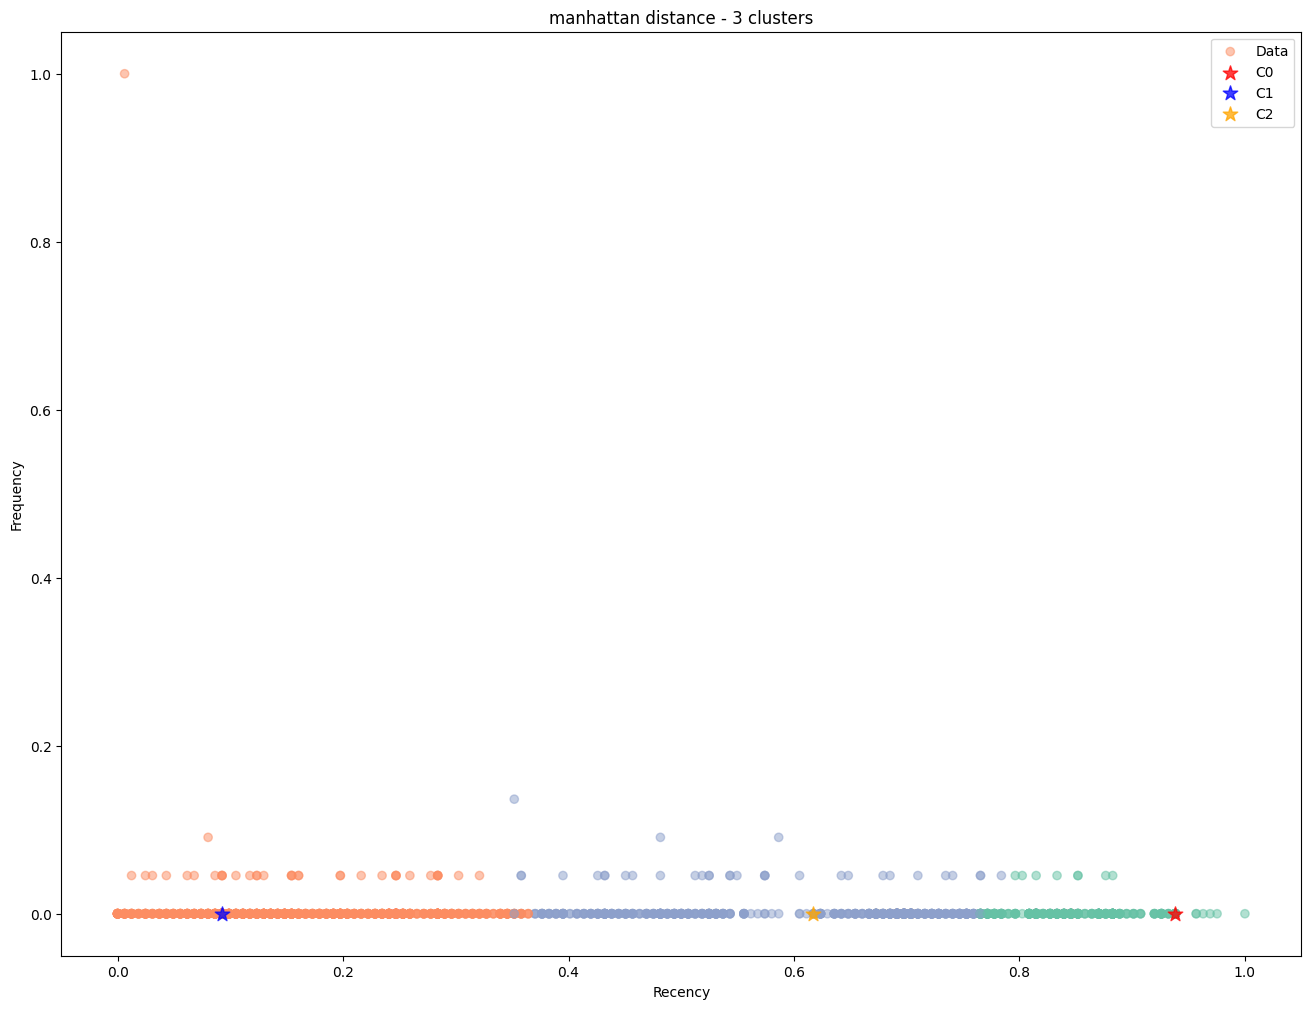

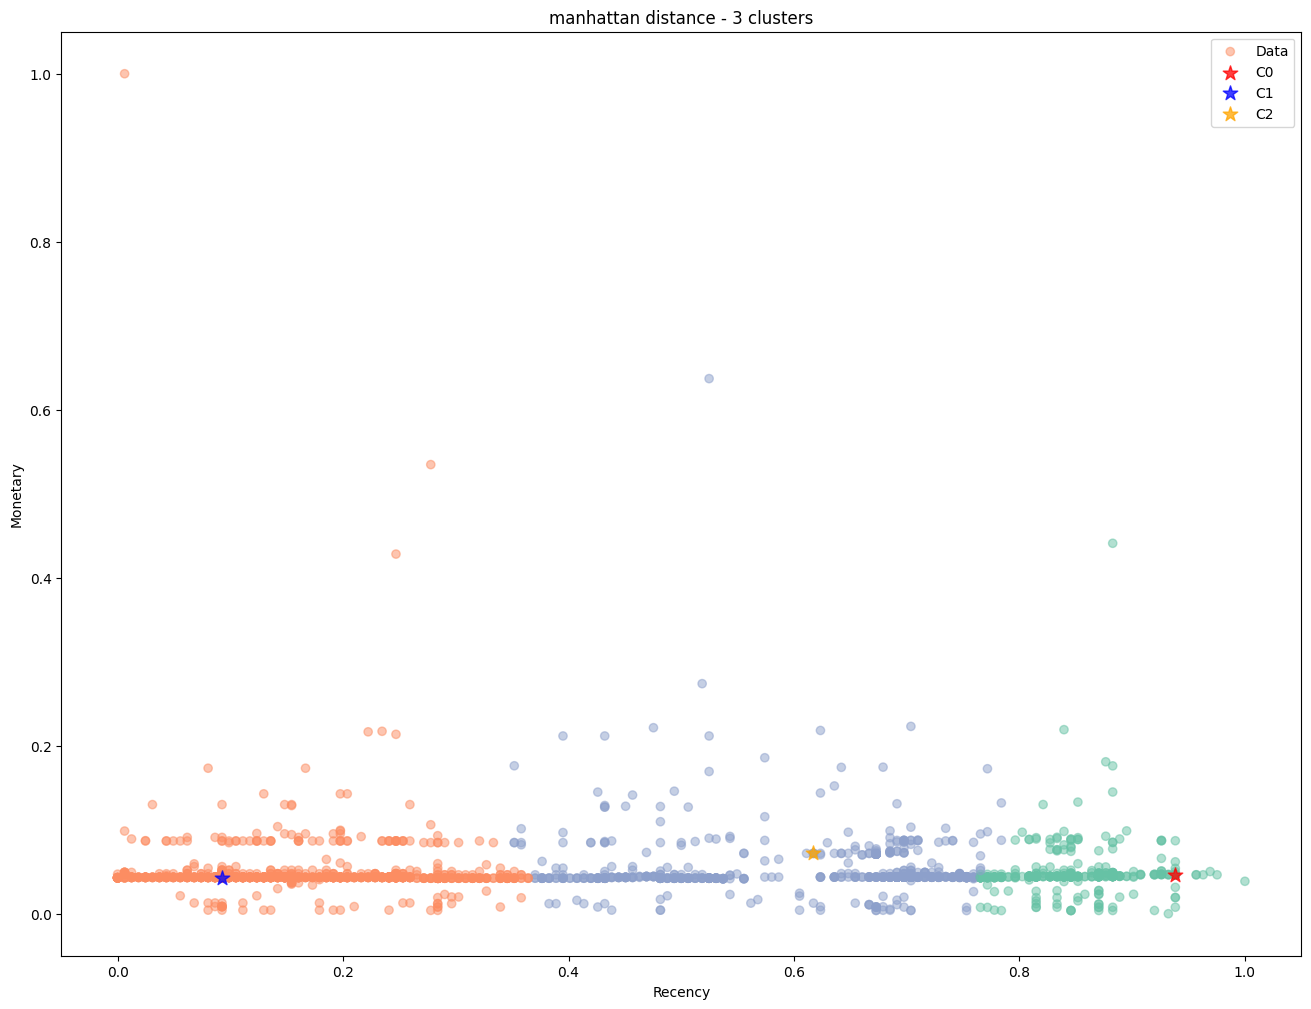

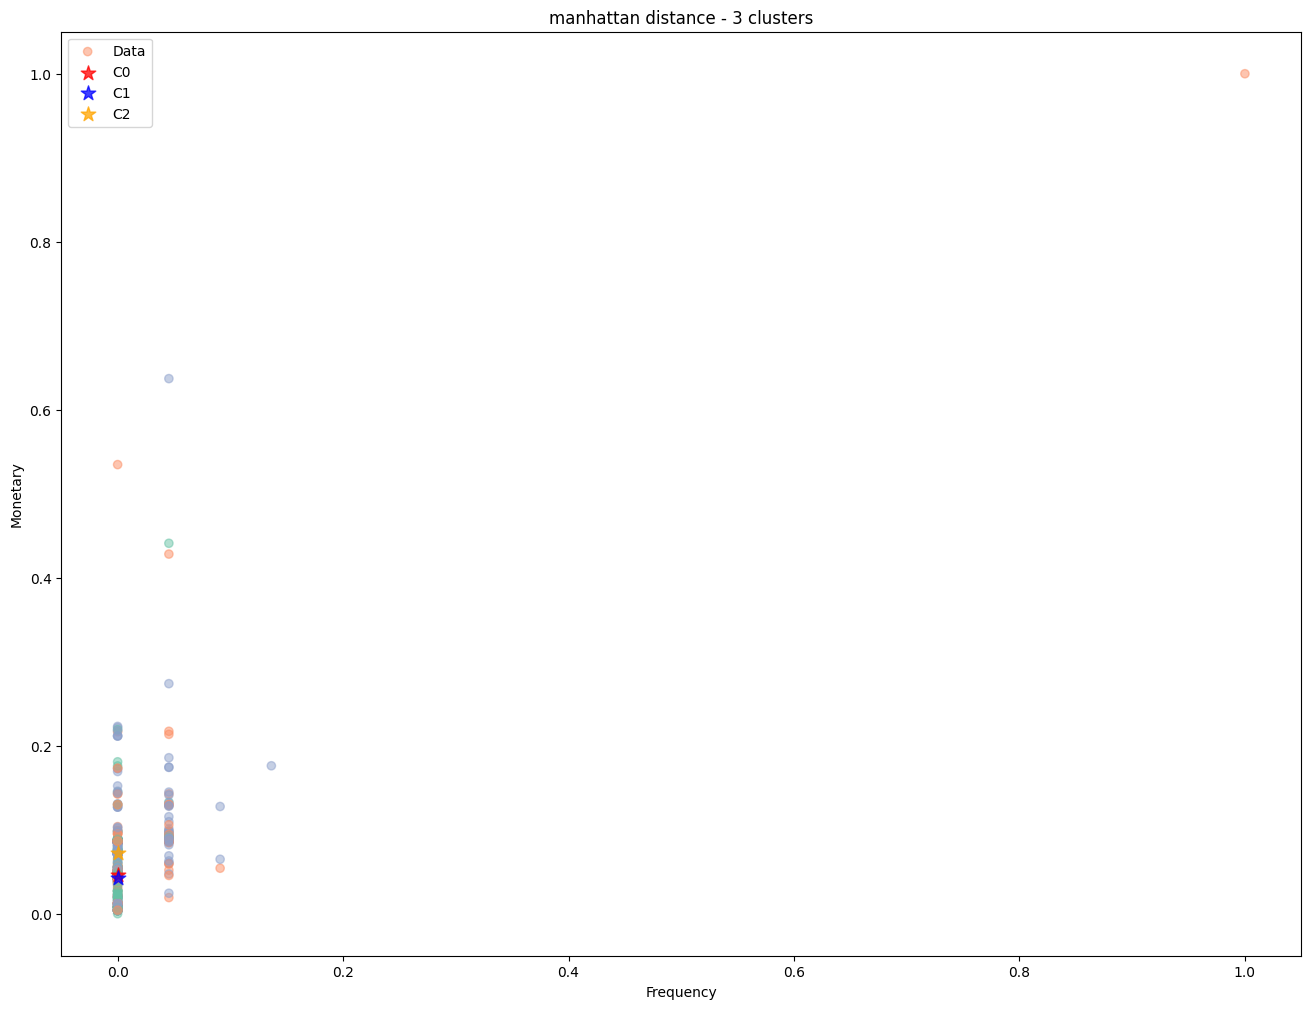

Completed chebyshev distance


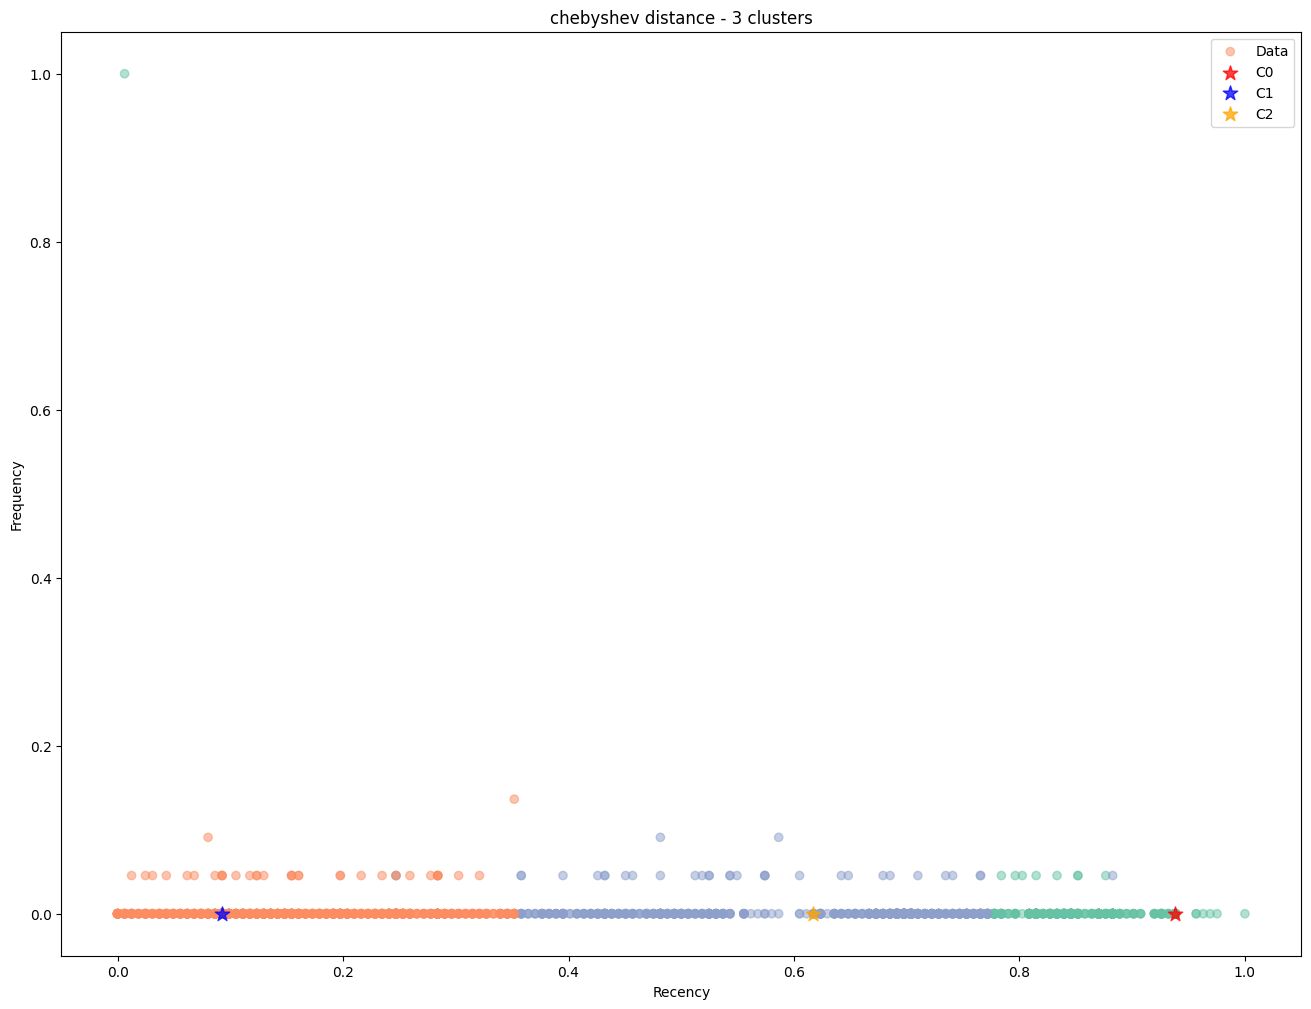

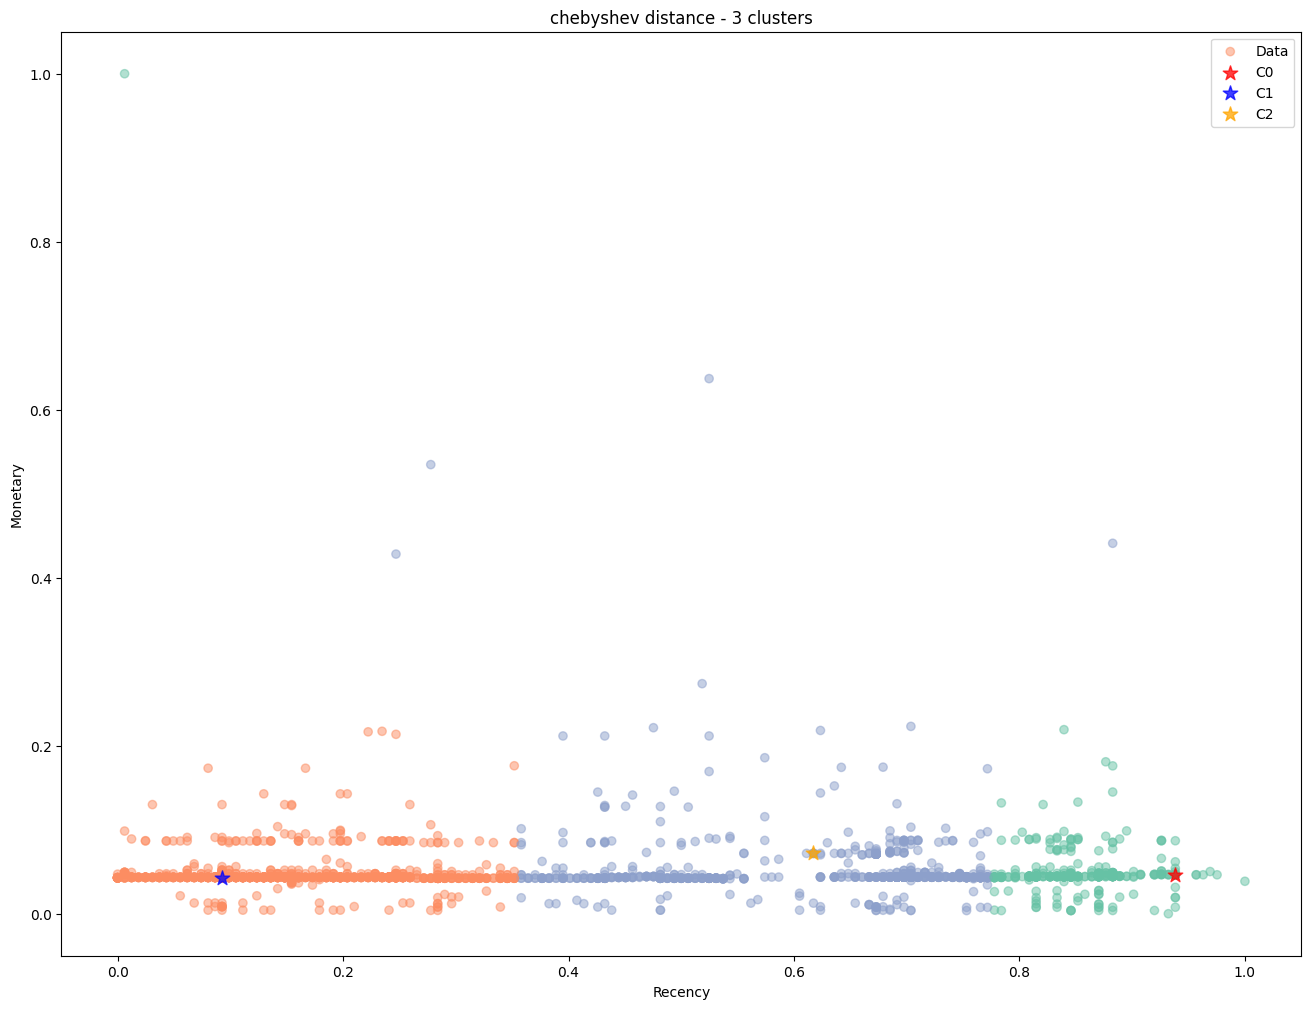

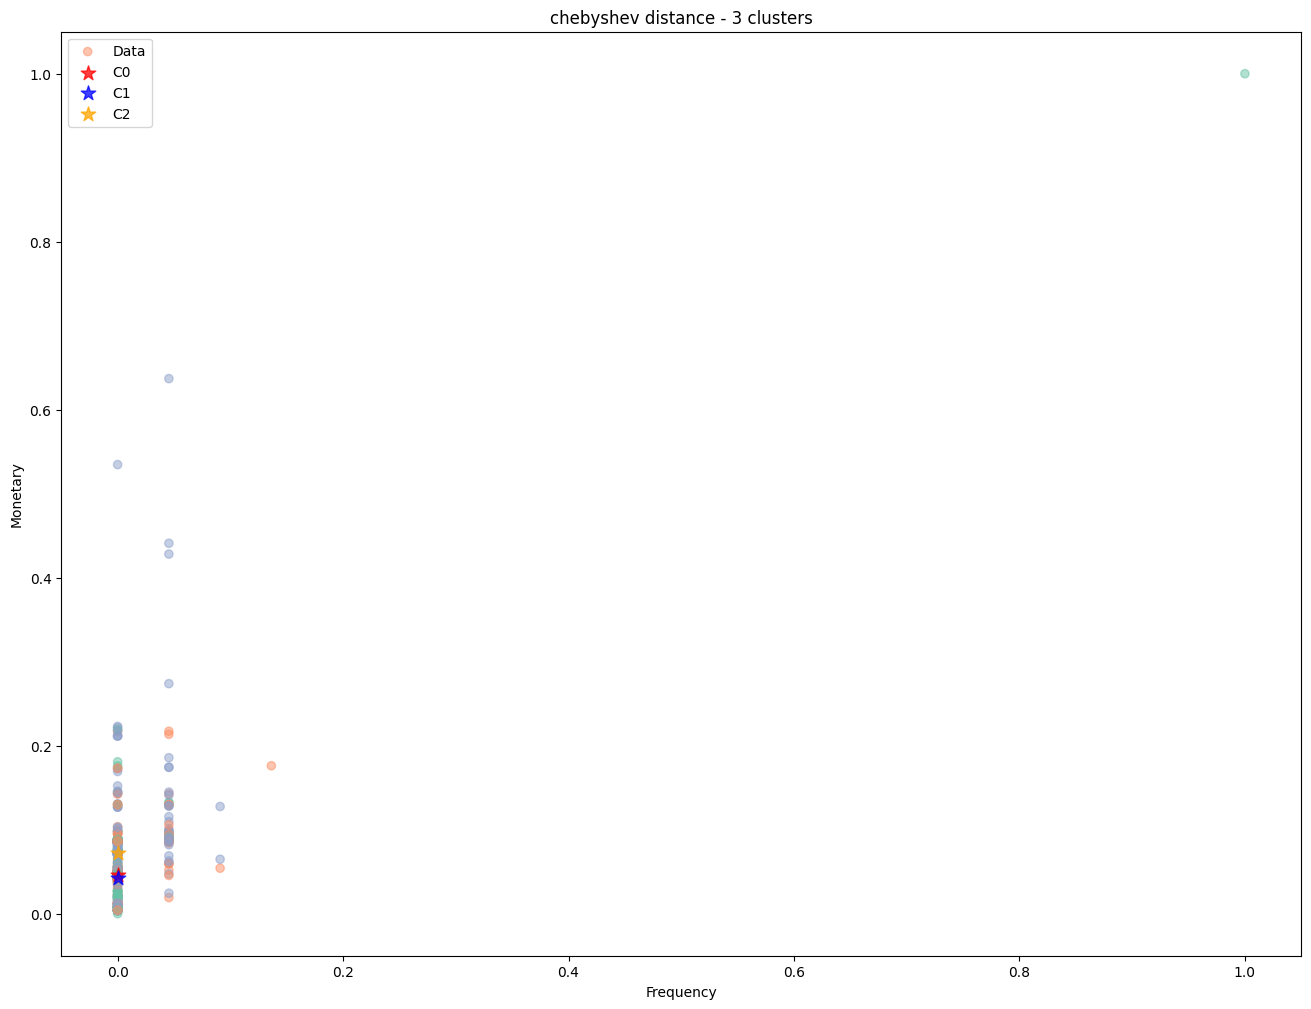

Clustering with 4 clusters:
Completed euclidean distance


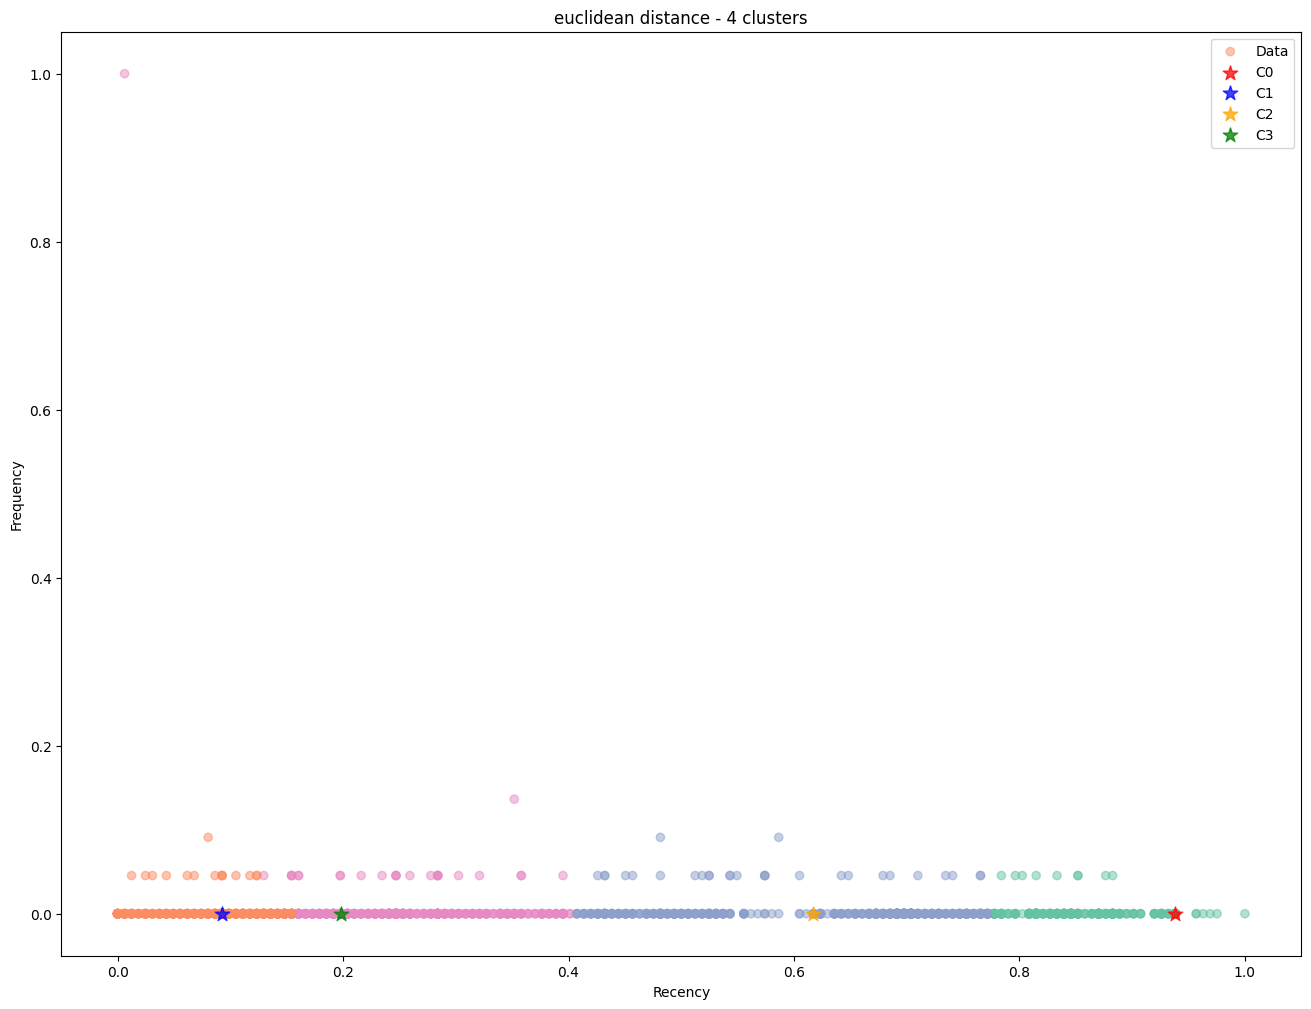

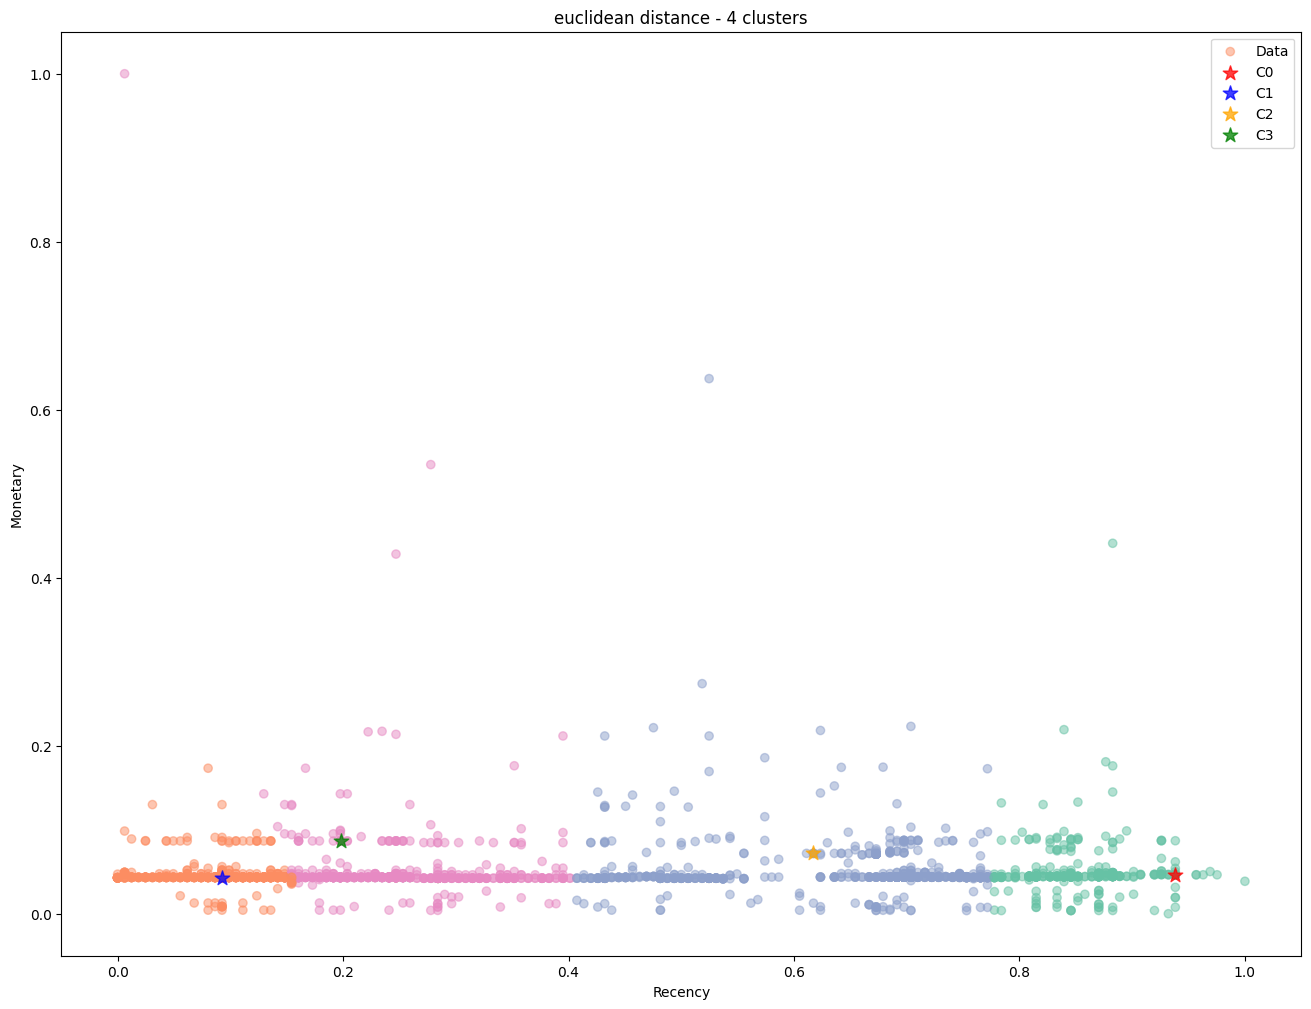

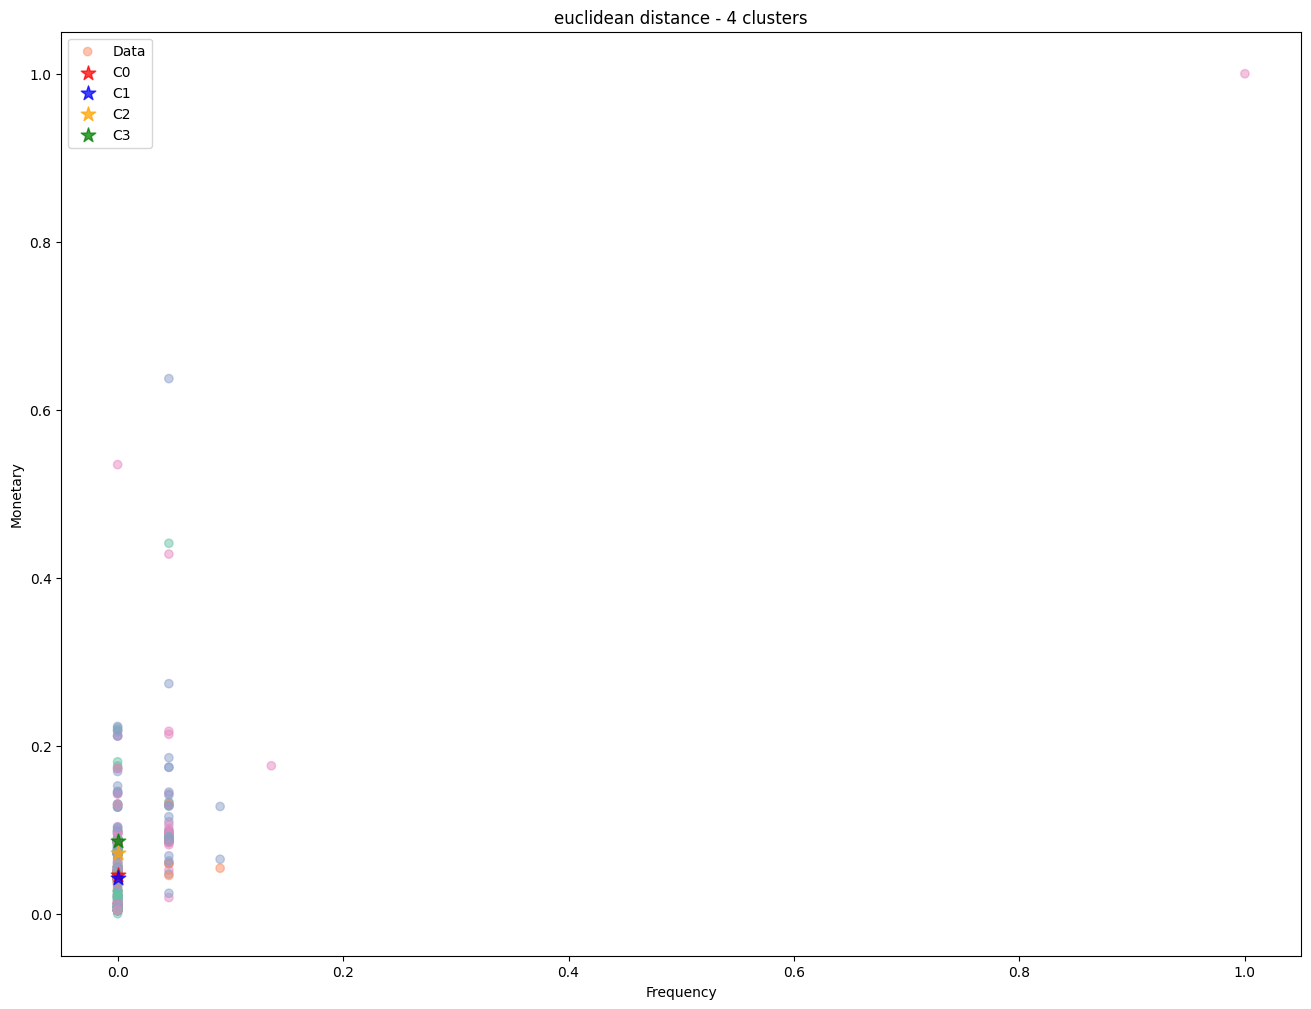

Completed manhattan distance


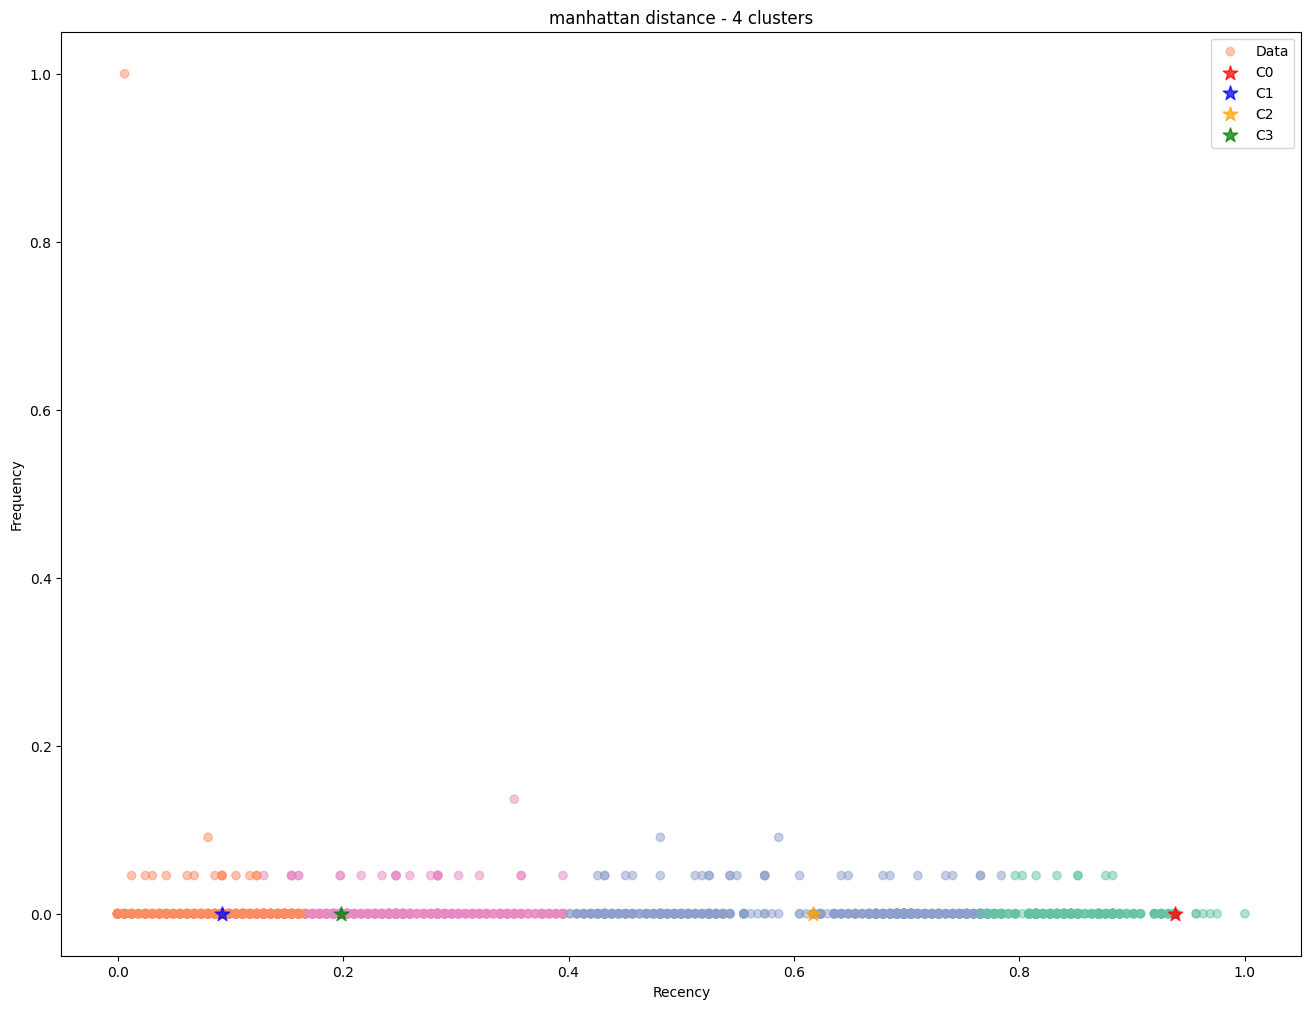

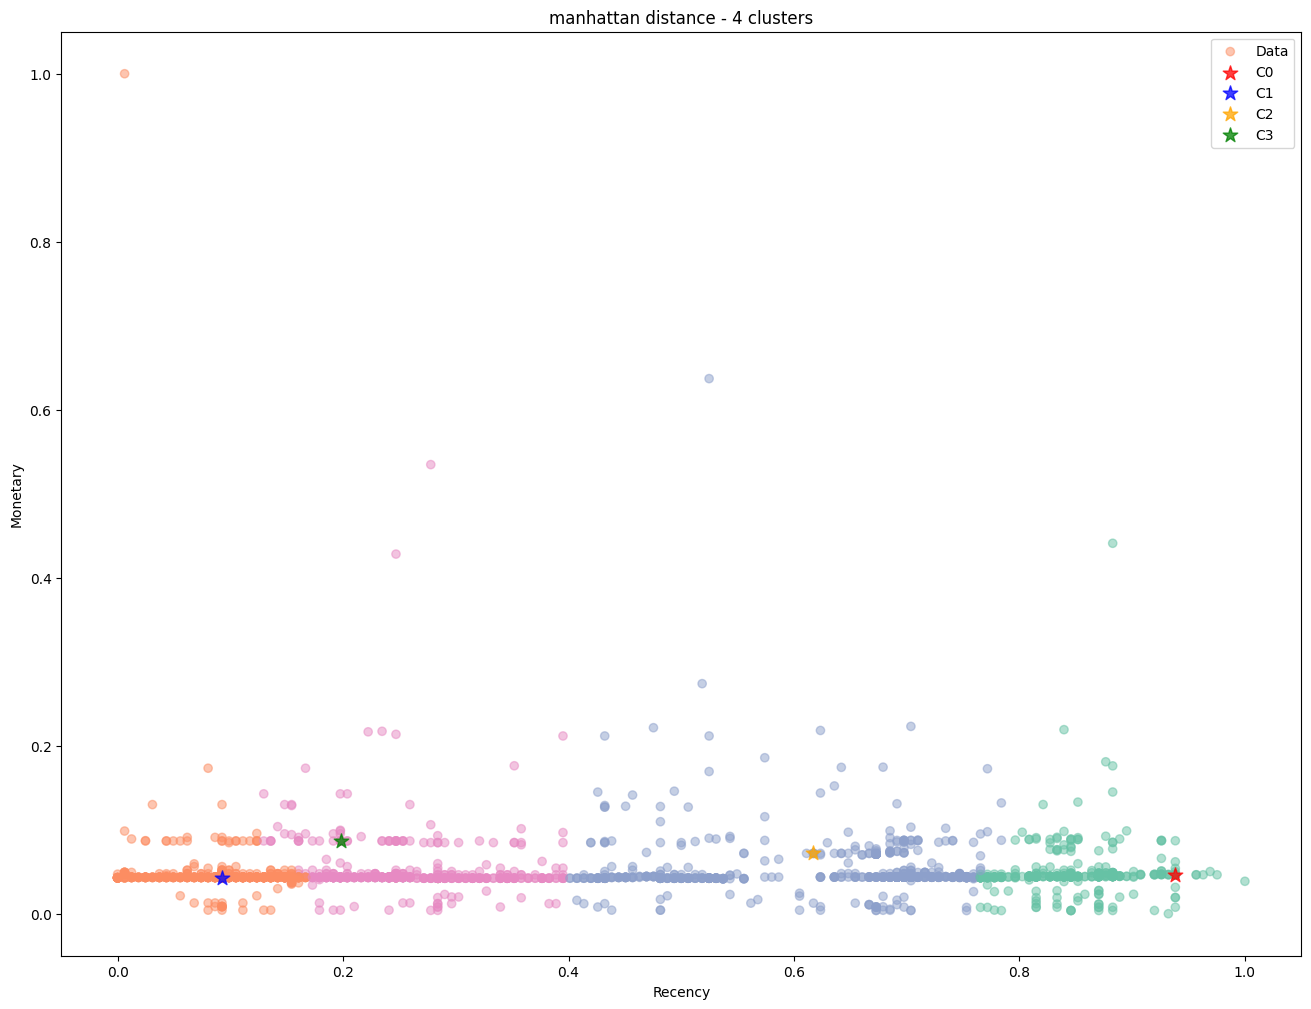

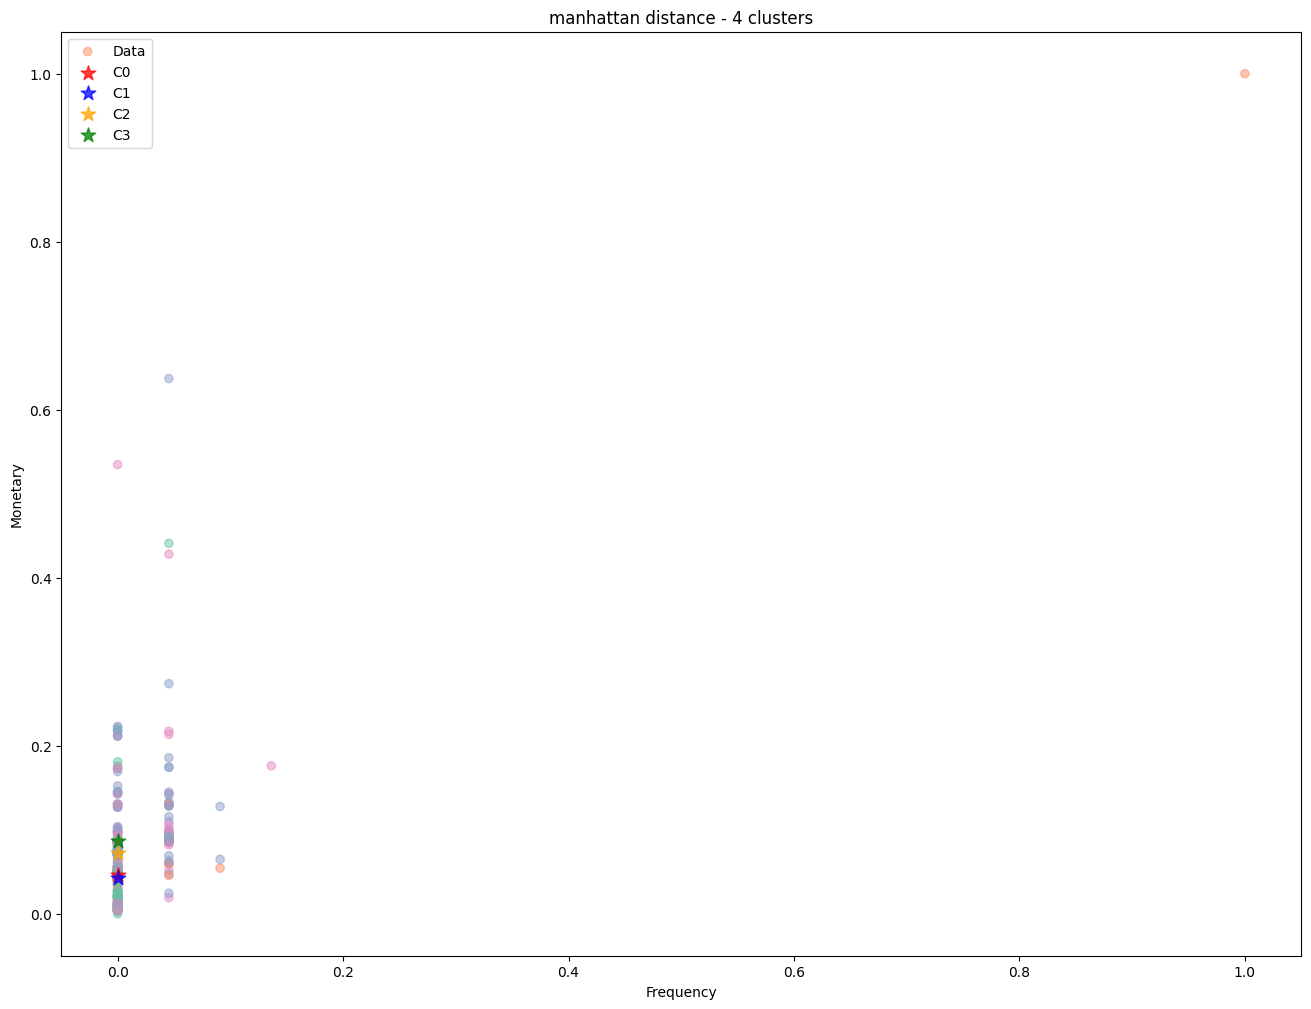

Completed chebyshev distance


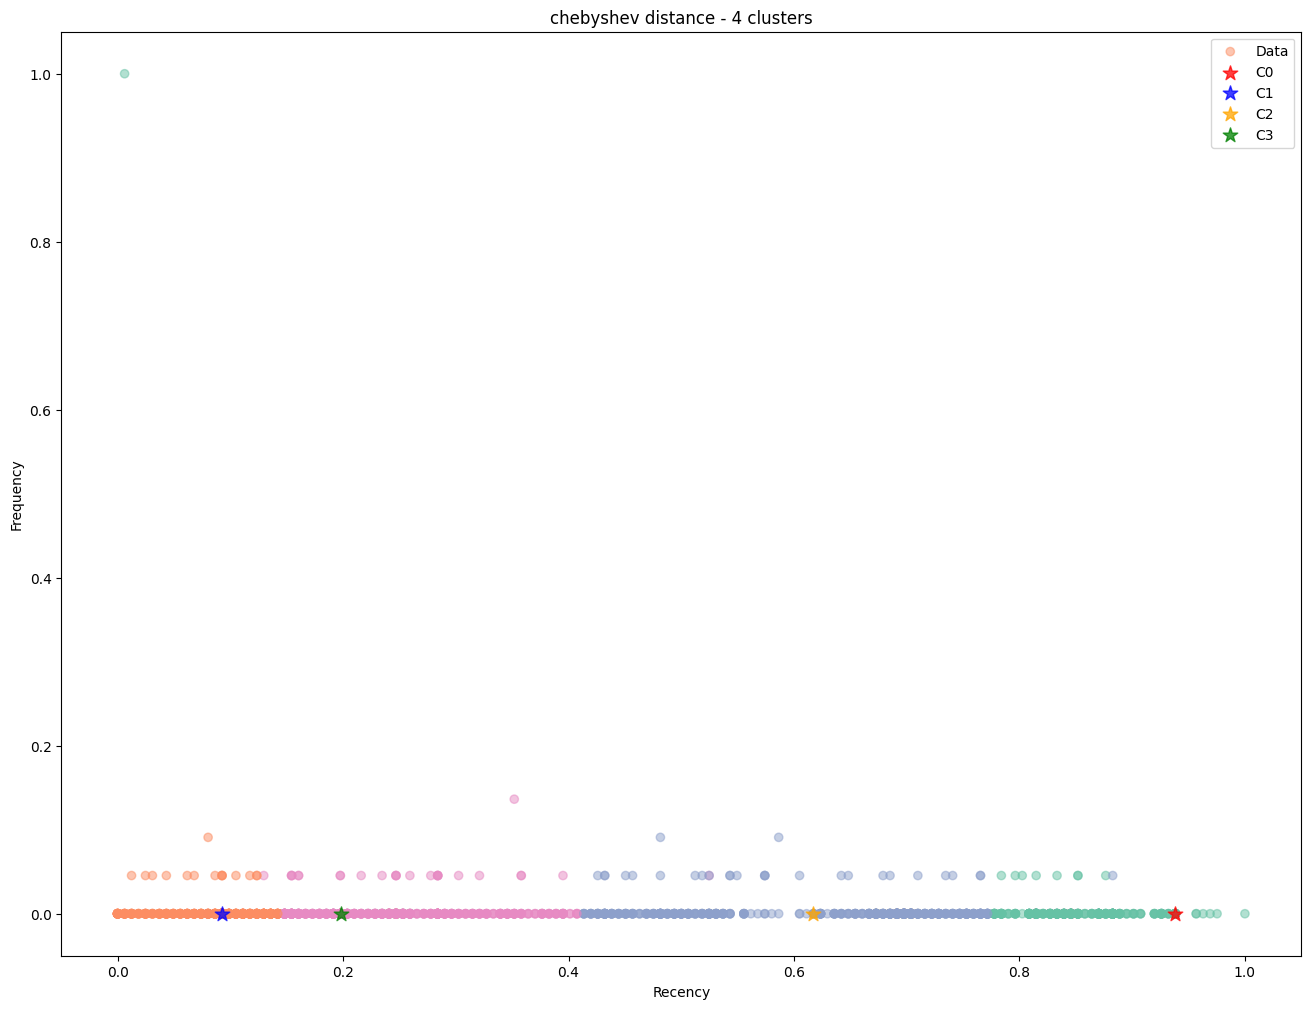

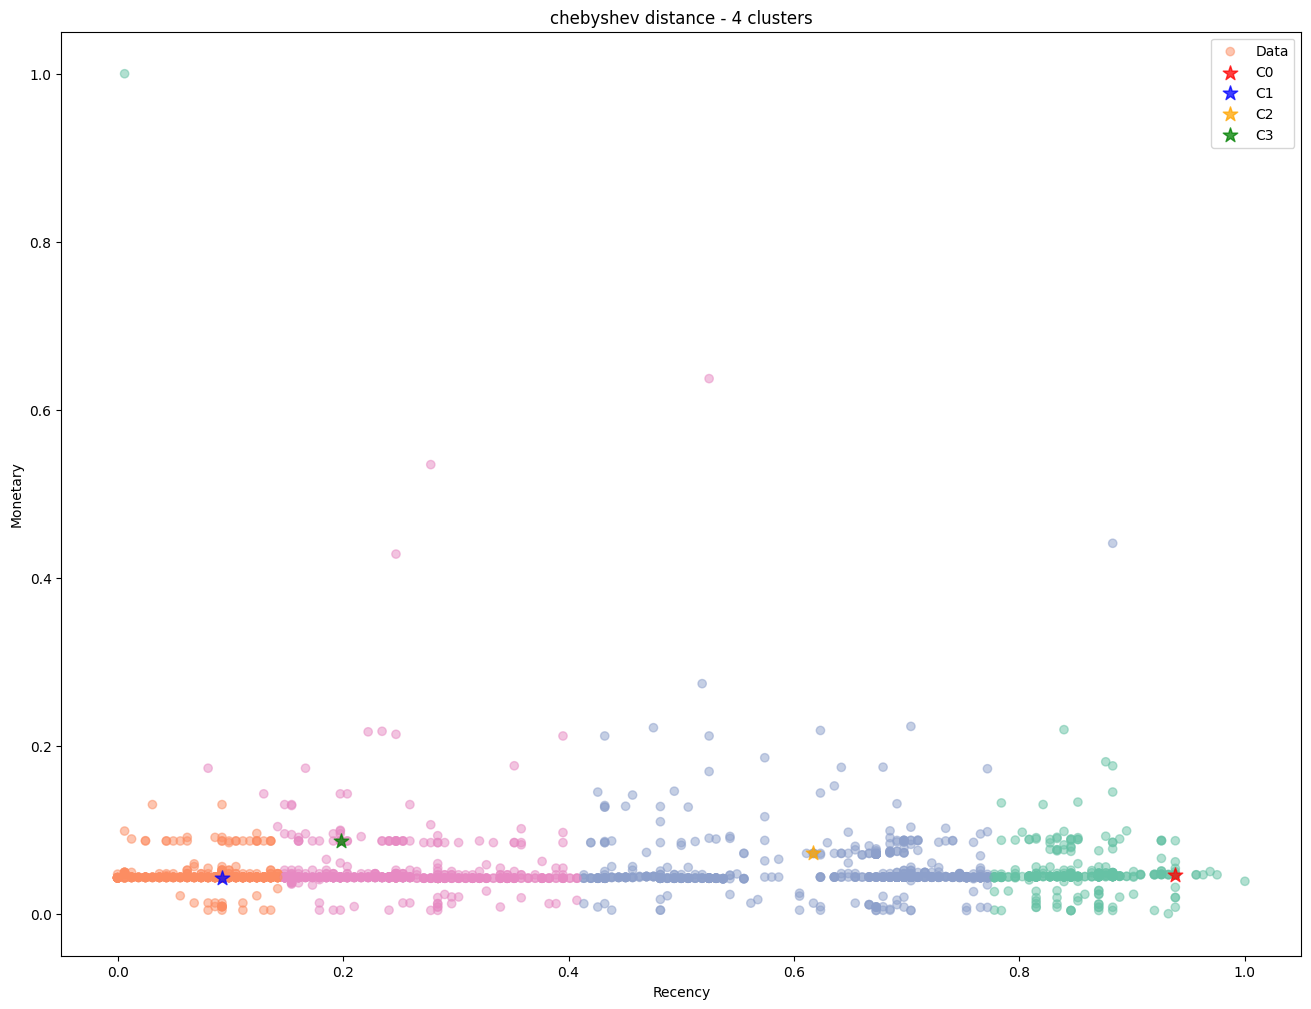

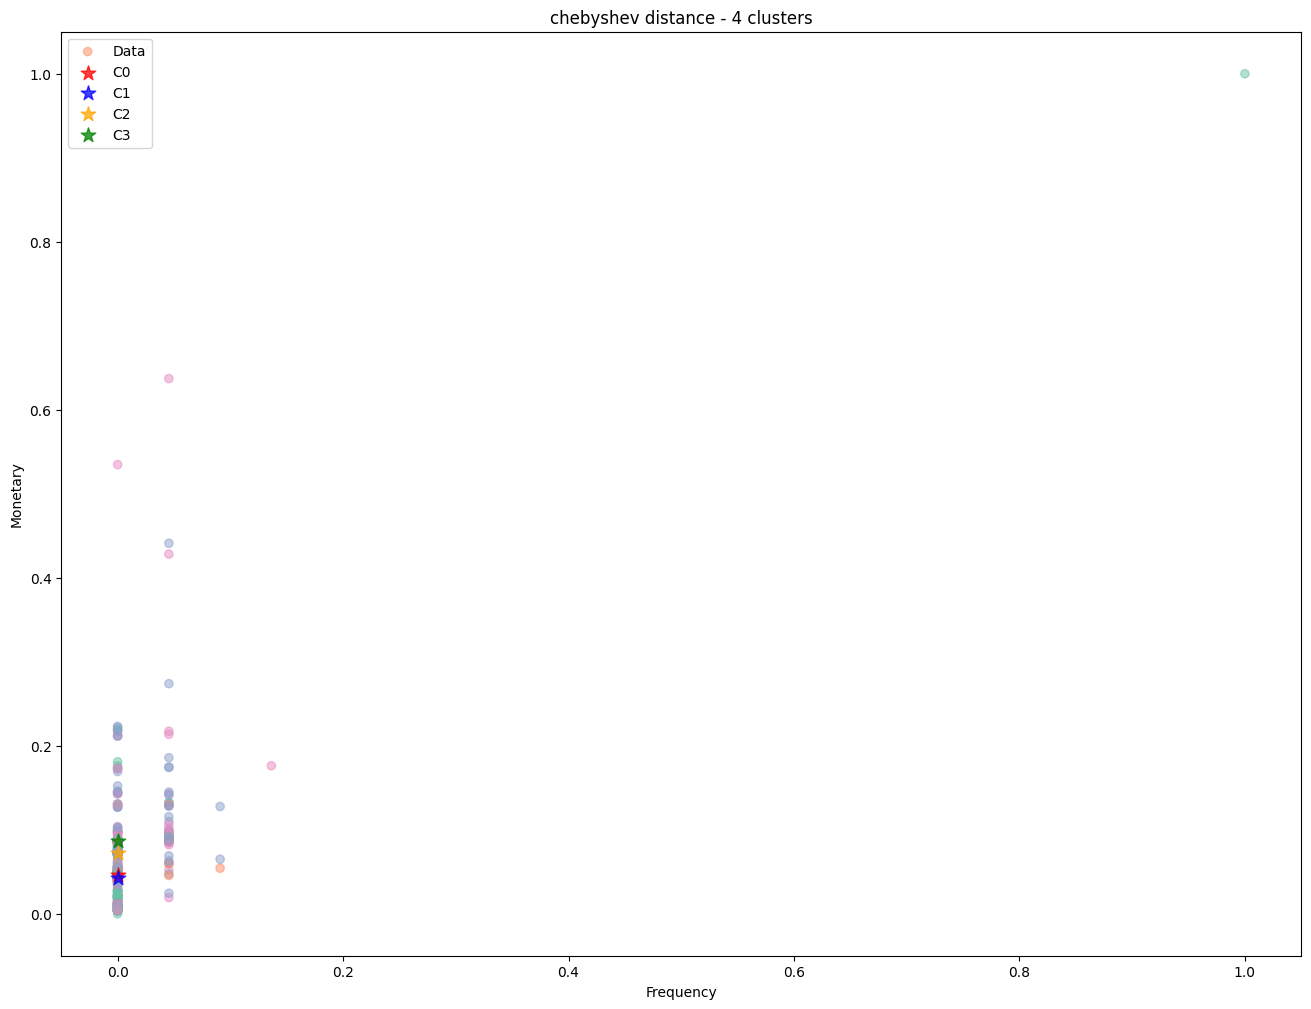

Clustering with 5 clusters:
Completed euclidean distance


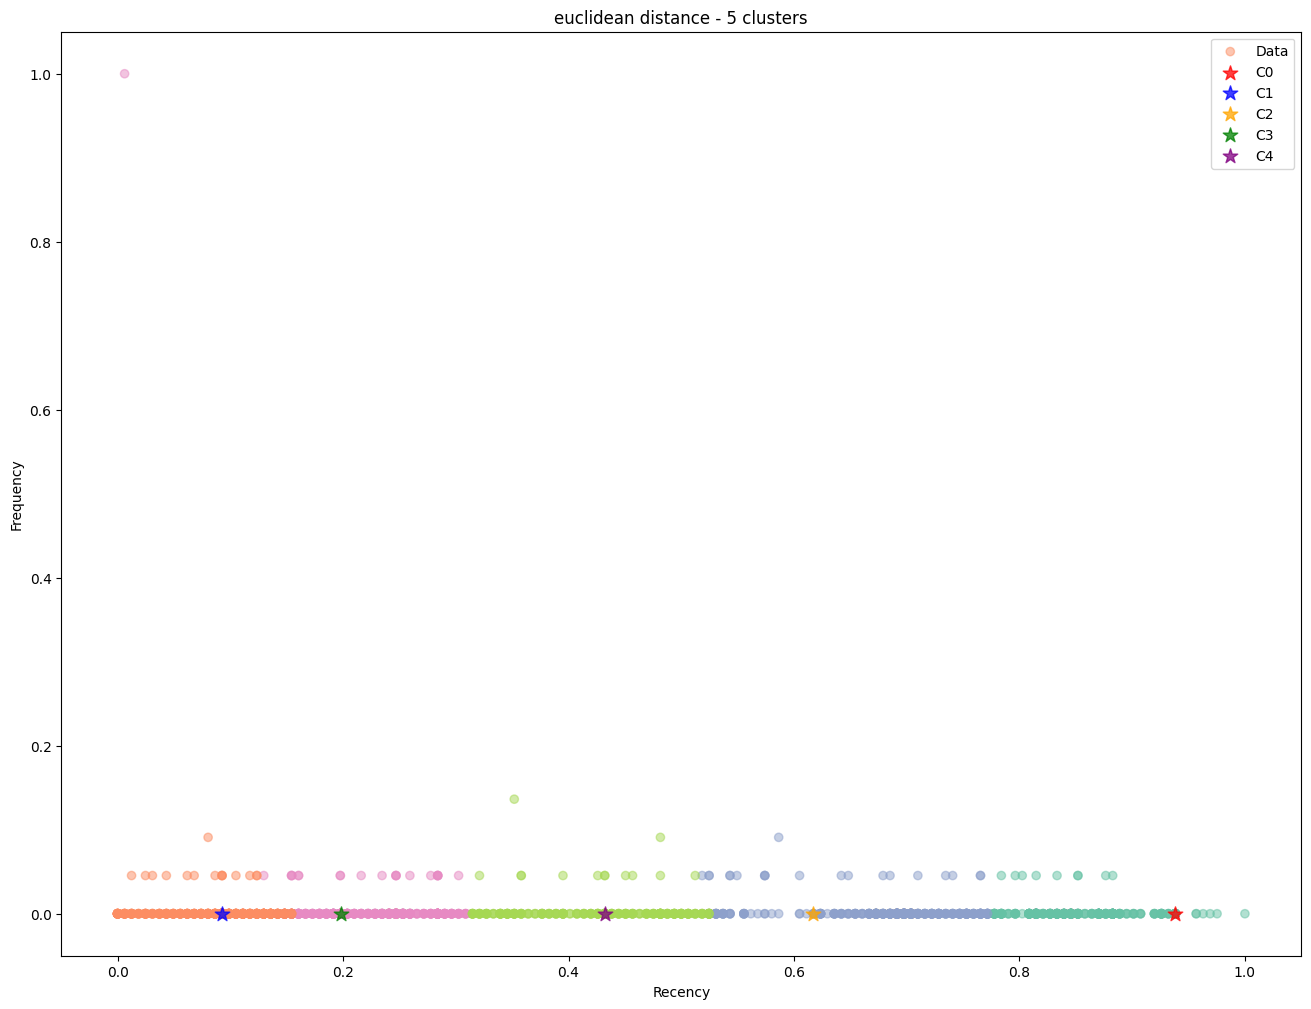

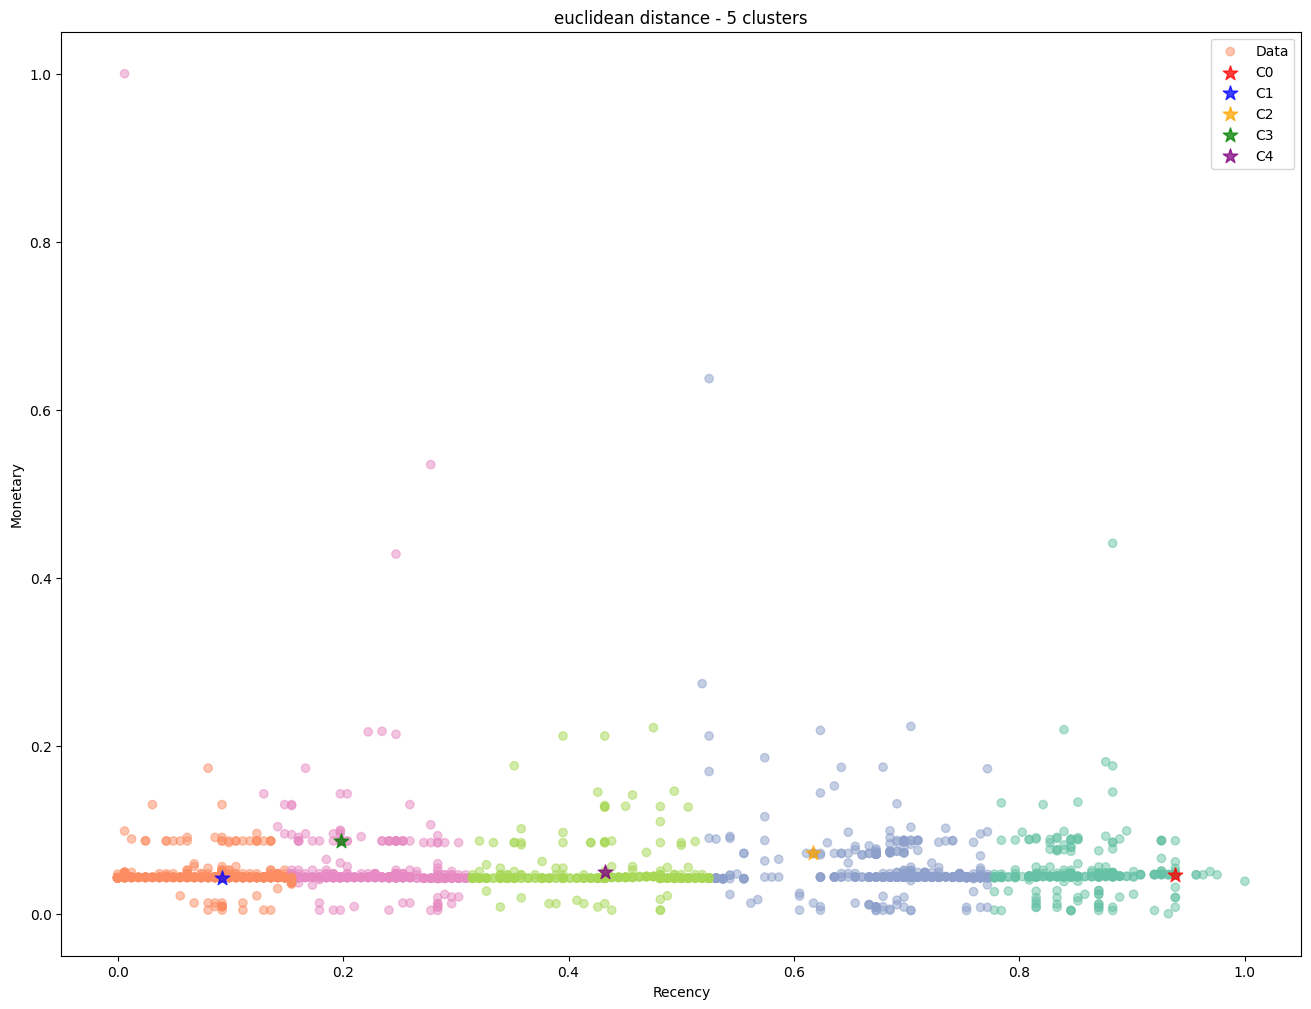

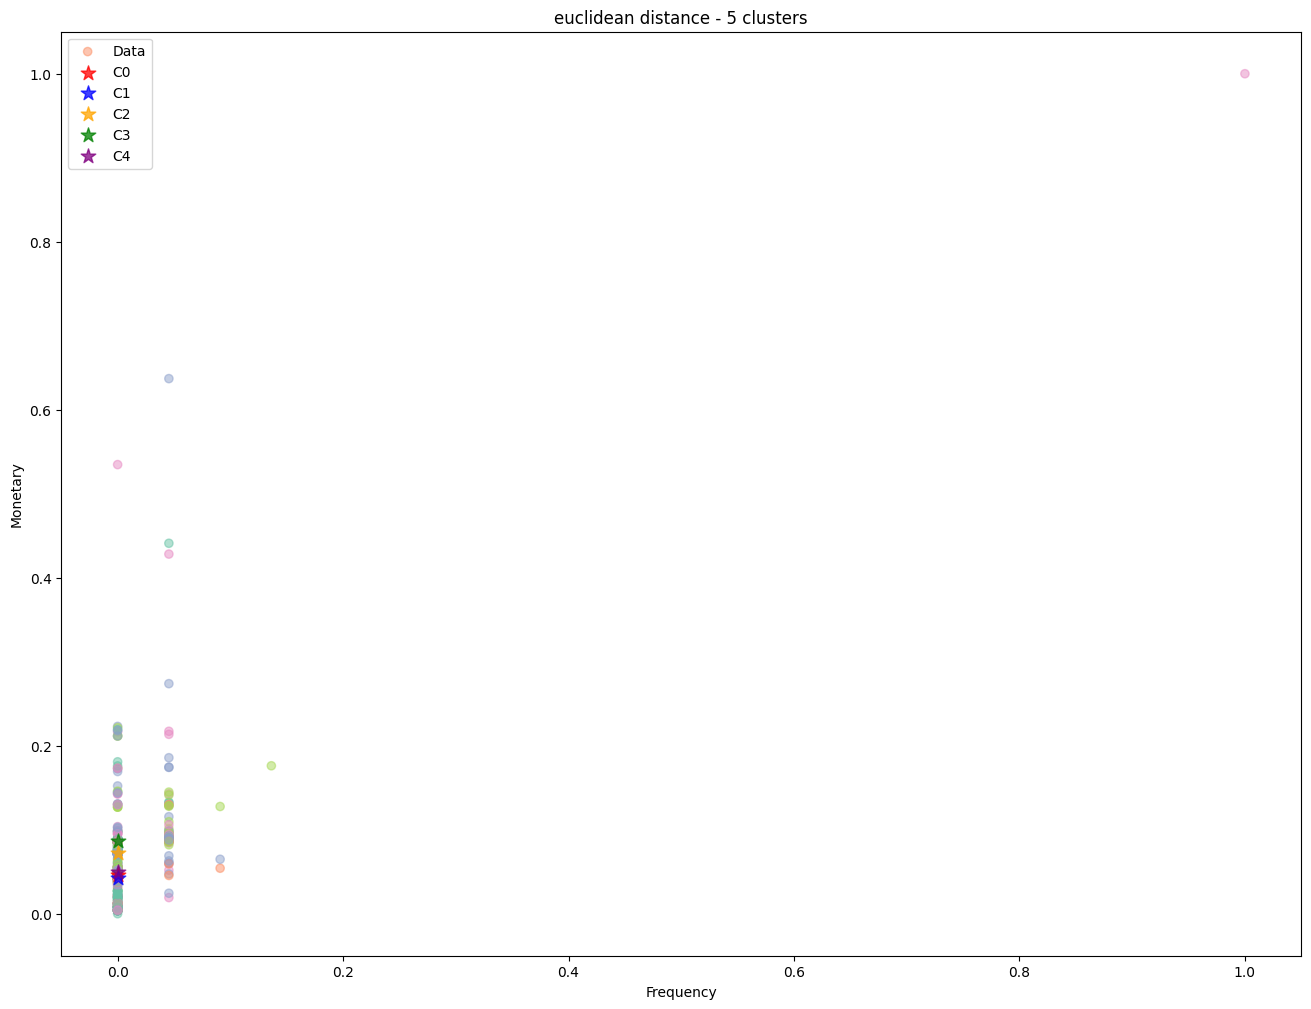

Completed manhattan distance


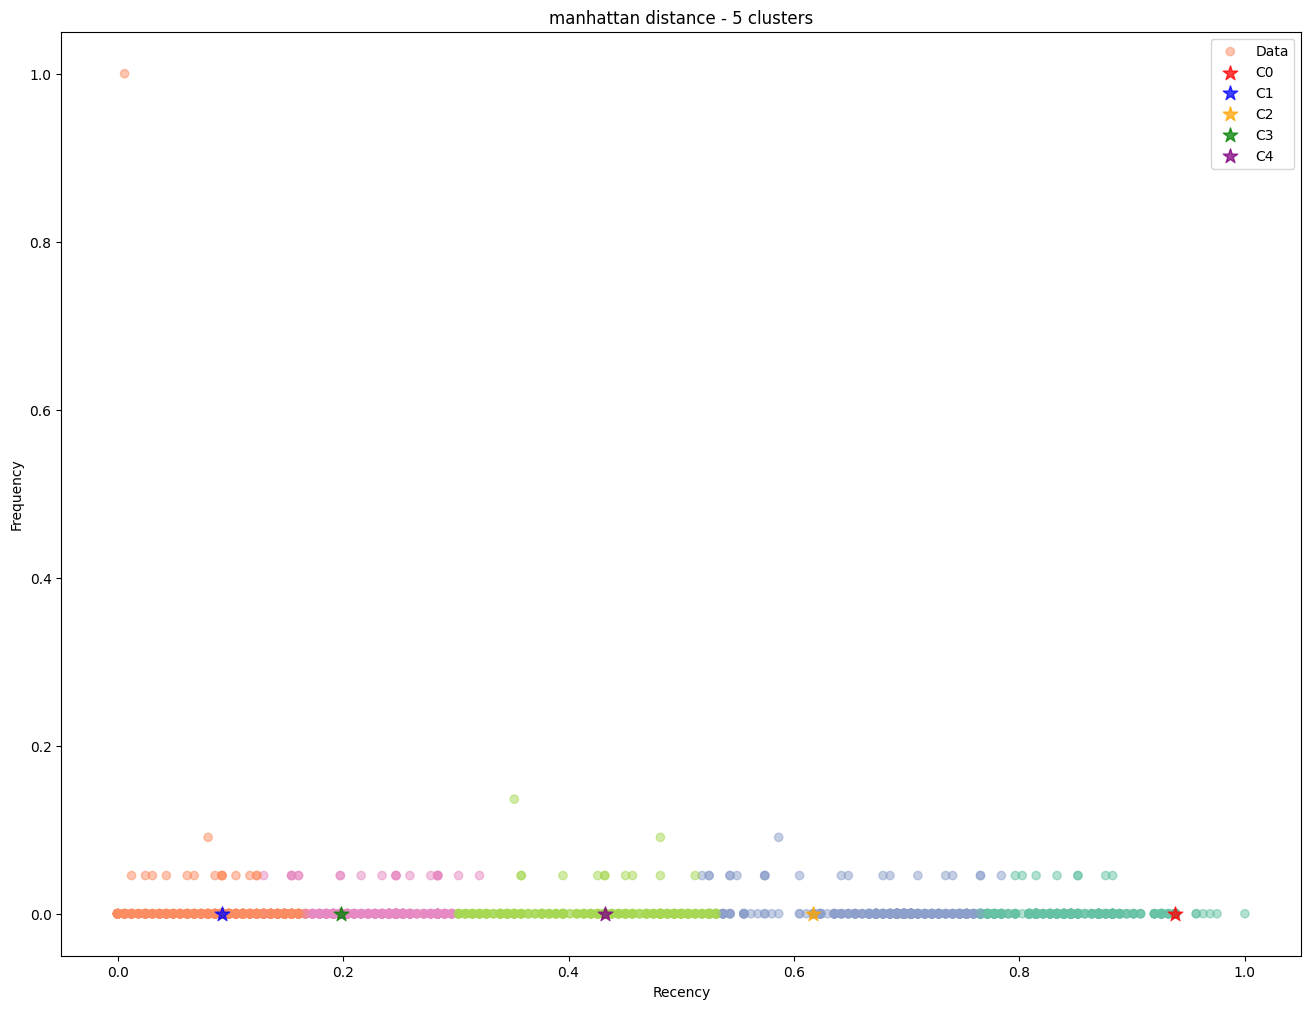

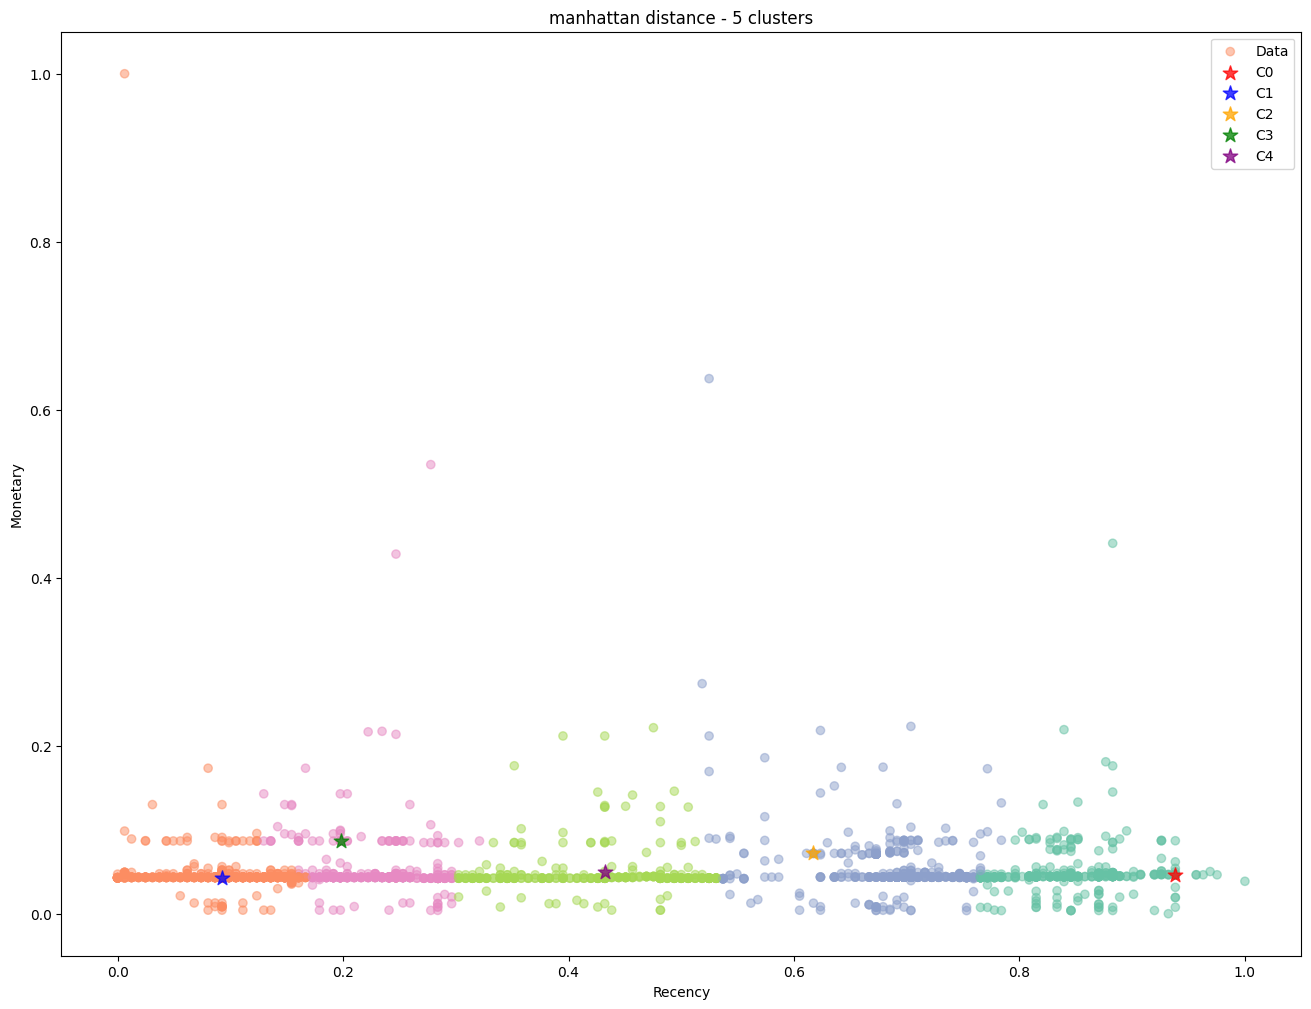

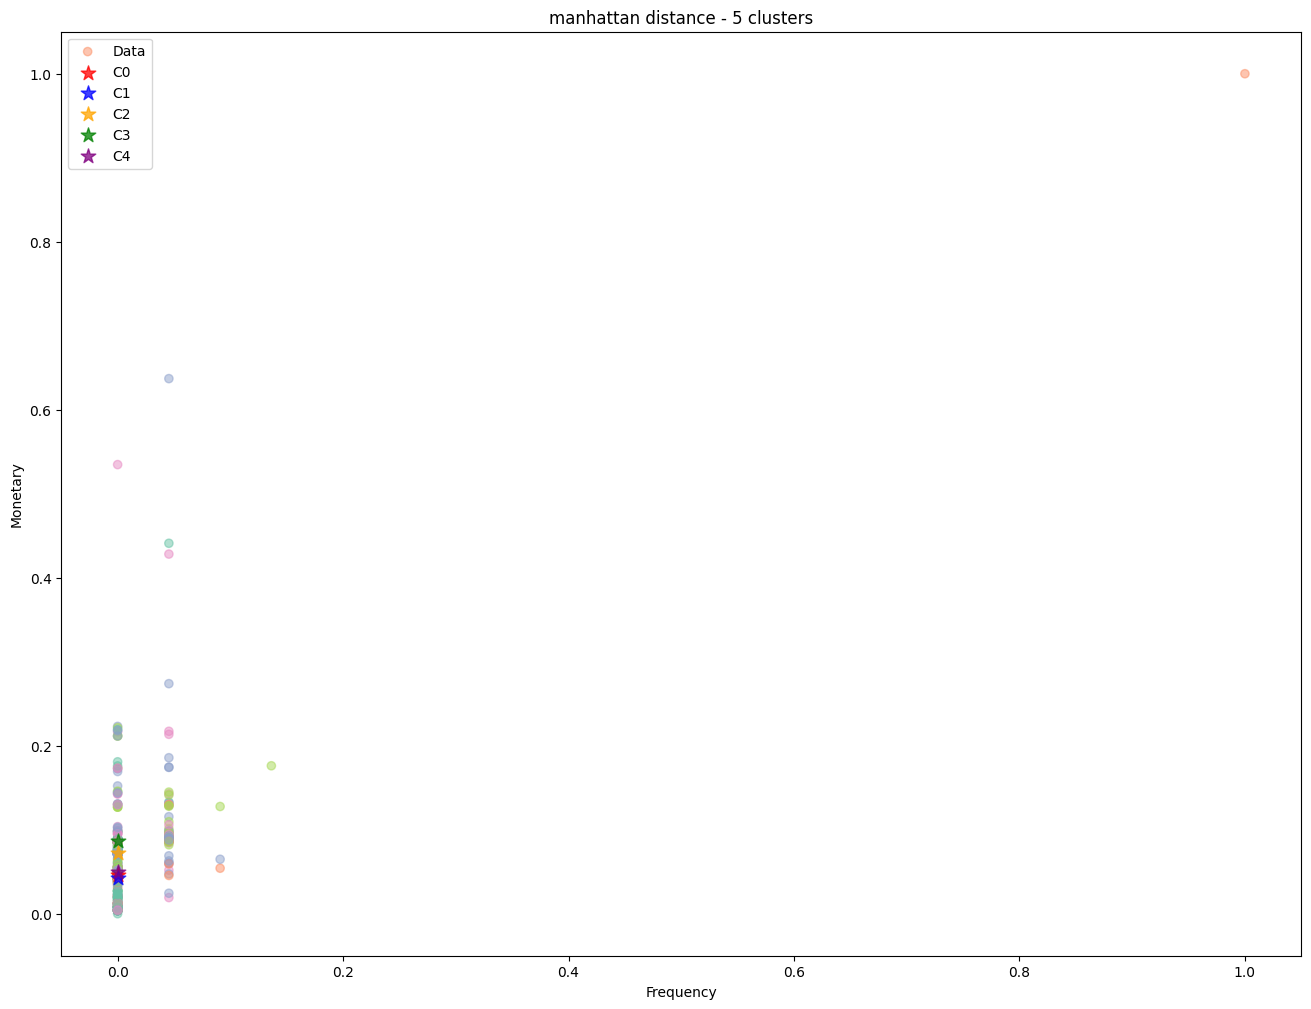

Completed chebyshev distance


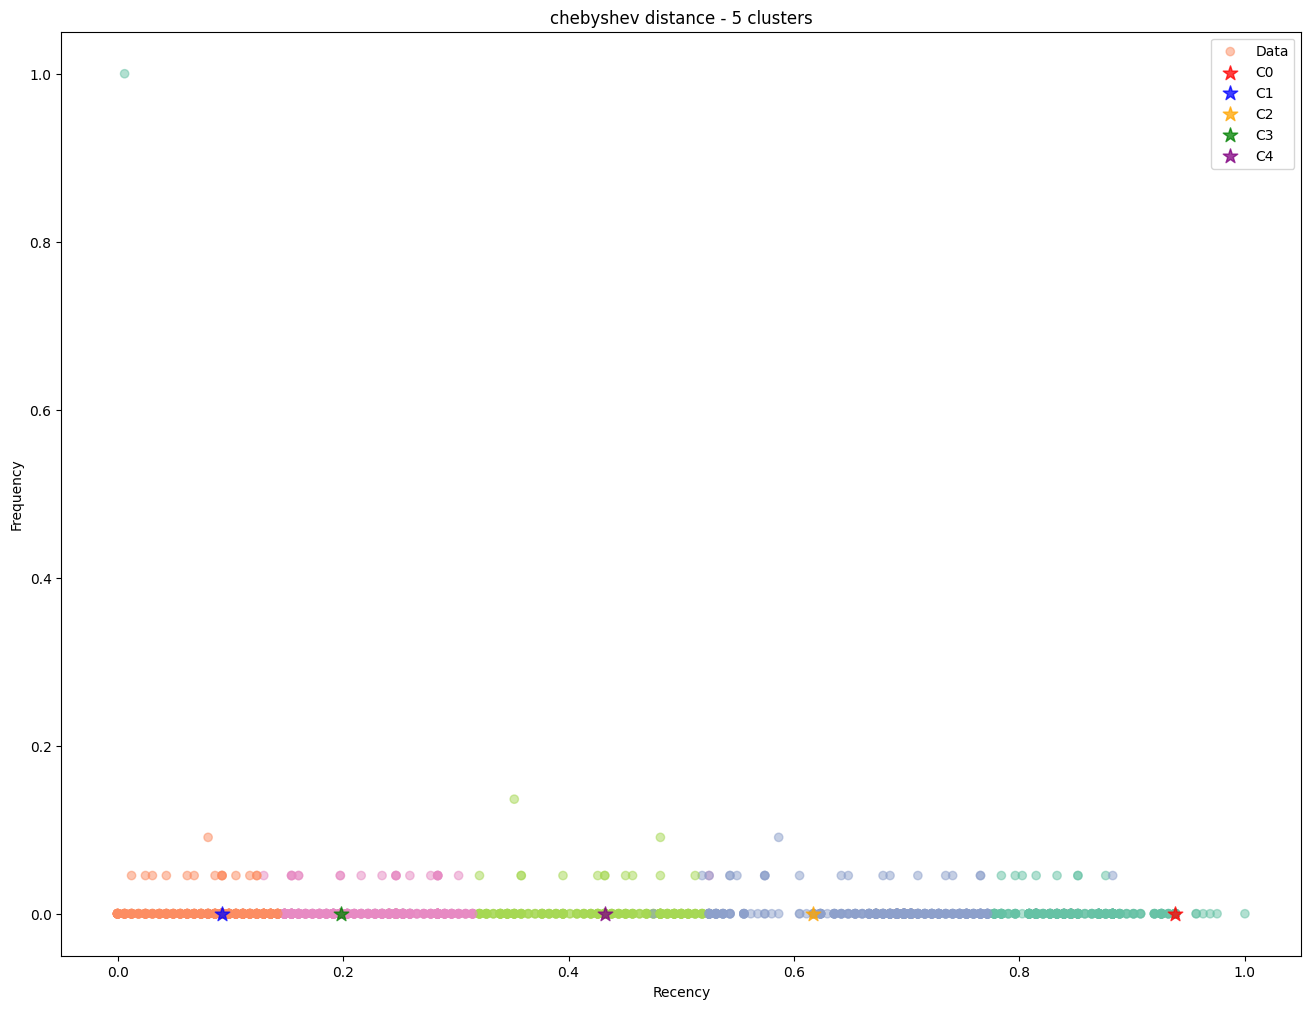

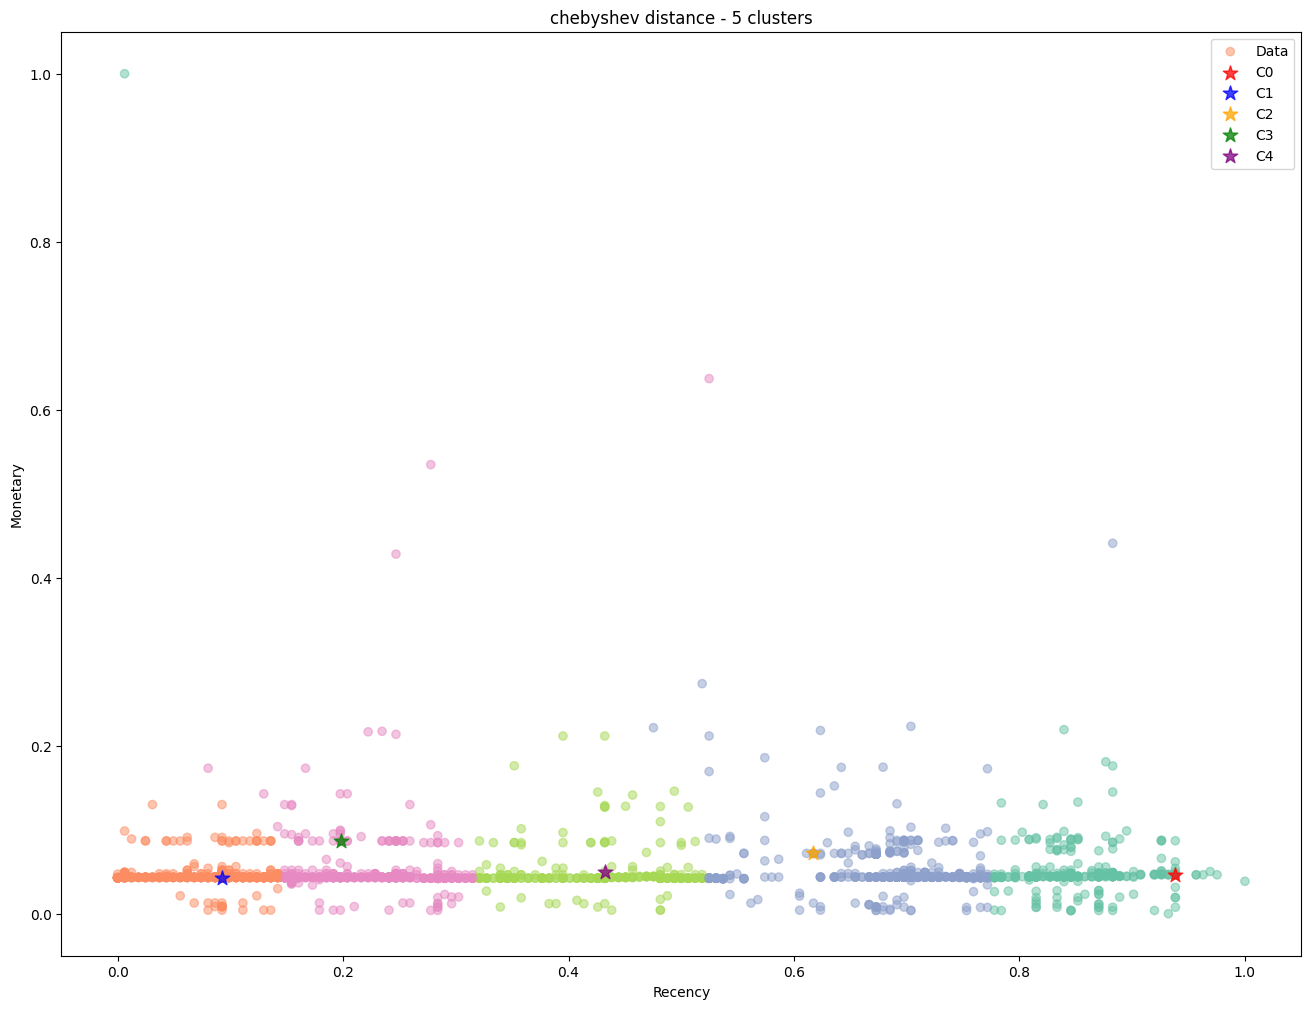

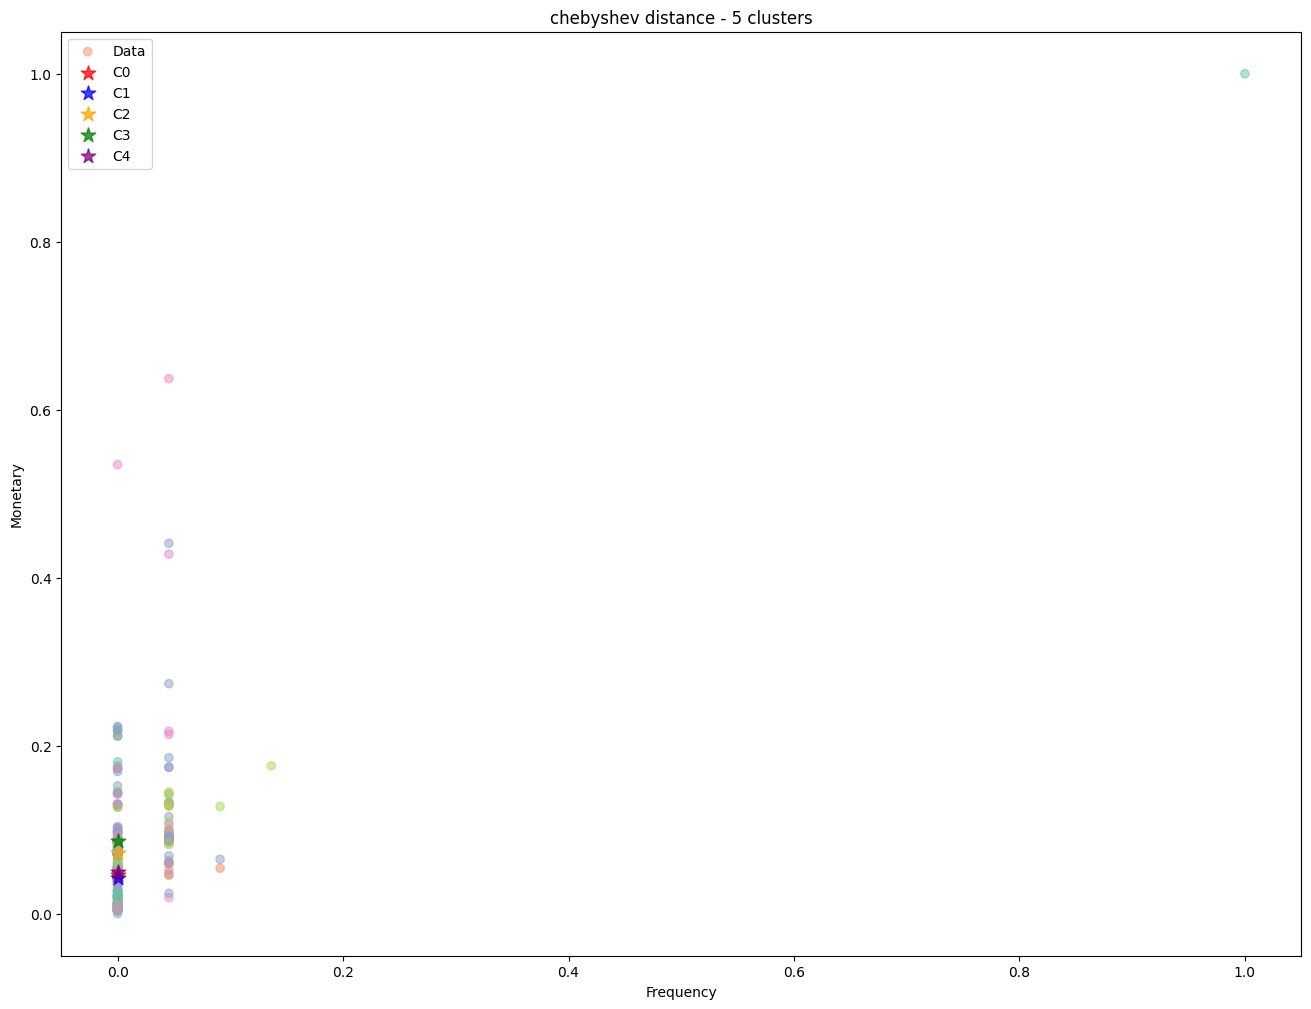

In [6]:
execute(df_scaled, medoids, [opsi1, opsi2, opsi3], (16, 12), output_plots=True, save_fig=False, output_labels=list_of_labels)

## Dataframe tanpa data yang dinormalisasikan

In [7]:
hasil_euclidean = df.copy()
hasil_manhattan = df.copy()
hasil_chebyshev = df.copy()

In [8]:
k = 2
for i in range(0, 12, 3):
    nama_kolom = f'Model K = {k}'
    hasil_euclidean[nama_kolom] = list_of_labels[i]
    hasil_manhattan[nama_kolom] = list_of_labels[i+1]
    hasil_chebyshev[nama_kolom] = list_of_labels[i+2]
    k += 1

In [9]:
hasil_euclidean

,Recency,Frequency,Monetary,Model K = 2,Model K = 3,Model K = 4,Model K = 5
0,650,2,230467,1,1,1,1
1,789,1,115035,0,0,0,0
2,726,1,109598,1,2,2,4
3,663,1,112147,1,1,1,1
4,770,1,111744,0,2,2,2
...,...,...,...,...,...,...,...
2233,673,1,112147,1,1,1,1
2234,748,1,186093,0,2,2,2
2235,690,1,112147,1,1,3,3
2236,680,1,224294,1,1,3,3


In [10]:
hasil_manhattan

,Recency,Frequency,Monetary,Model K = 2,Model K = 3,Model K = 4,Model K = 5
0,650,2,230467,1,1,1,1
1,789,1,115035,0,0,0,0
2,726,1,109598,1,2,2,4
3,663,1,112147,1,1,1,1
4,770,1,111744,0,2,2,2
...,...,...,...,...,...,...,...
2233,673,1,112147,1,1,1,1
2234,748,1,186093,0,2,2,2
2235,690,1,112147,1,1,3,3
2236,680,1,224294,1,1,3,3


In [11]:
hasil_chebyshev

,Recency,Frequency,Monetary,Model K = 2,Model K = 3,Model K = 4,Model K = 5
0,650,2,230467,1,1,1,1
1,789,1,115035,0,0,0,0
2,726,1,109598,1,2,2,4
3,663,1,112147,1,1,1,1
4,770,1,111744,0,2,2,2
...,...,...,...,...,...,...,...
2233,673,1,112147,1,1,3,3
2234,748,1,186093,0,2,2,2
2235,690,1,112147,1,1,3,3
2236,680,1,224294,1,1,3,3


## Dataframe dengan data yang dinormalisasikan

In [12]:
hasil_euclidean2 = df.copy()
hasil_manhattan2 = df.copy()
hasil_chebyshev2 = df.copy()
df_list_norm = [hasil_euclidean2, hasil_manhattan2, hasil_chebyshev2]

In [13]:
for hasil2 in df_list_norm:
    for nama_kolom in df_scaled.columns:
        hasil2[nama_kolom + "_Norm"] = df_scaled[nama_kolom]

In [14]:
k = 2
for i in range(0, 12, 3):
    nama_kolom = f'Model K = {k}'
    hasil_euclidean2[nama_kolom] = list_of_labels[i]
    hasil_manhattan2[nama_kolom] = list_of_labels[i+1]
    hasil_chebyshev2[nama_kolom] = list_of_labels[i+2]
    k += 1

In [15]:
hasil_euclidean2

,Recency,Frequency,Monetary,Recency_Norm,Frequency_Norm,Monetary_Norm,Model K = 2,Model K = 3,Model K = 4,Model K = 5
0,650,2,230467,0.012346,0.045455,0.088999,1,1,1,1
1,789,1,115035,0.870370,0.000000,0.044423,0,0,0,0
2,726,1,109598,0.481481,0.000000,0.042323,1,2,2,4
3,663,1,112147,0.092593,0.000000,0.043308,1,1,1,1
4,770,1,111744,0.753086,0.000000,0.043152,0,2,2,2
...,...,...,...,...,...,...,...,...,...,...
2233,673,1,112147,0.154321,0.000000,0.043308,1,1,1,1
2234,748,1,186093,0.617284,0.000000,0.071863,0,2,2,2
2235,690,1,112147,0.259259,0.000000,0.043308,1,1,3,3
2236,680,1,224294,0.197531,0.000000,0.086615,1,1,3,3


In [16]:
hasil_manhattan2

,Recency,Frequency,Monetary,Recency_Norm,Frequency_Norm,Monetary_Norm,Model K = 2,Model K = 3,Model K = 4,Model K = 5
0,650,2,230467,0.012346,0.045455,0.088999,1,1,1,1
1,789,1,115035,0.870370,0.000000,0.044423,0,0,0,0
2,726,1,109598,0.481481,0.000000,0.042323,1,2,2,4
3,663,1,112147,0.092593,0.000000,0.043308,1,1,1,1
4,770,1,111744,0.753086,0.000000,0.043152,0,2,2,2
...,...,...,...,...,...,...,...,...,...,...
2233,673,1,112147,0.154321,0.000000,0.043308,1,1,1,1
2234,748,1,186093,0.617284,0.000000,0.071863,0,2,2,2
2235,690,1,112147,0.259259,0.000000,0.043308,1,1,3,3
2236,680,1,224294,0.197531,0.000000,0.086615,1,1,3,3


In [17]:
hasil_chebyshev2

,Recency,Frequency,Monetary,Recency_Norm,Frequency_Norm,Monetary_Norm,Model K = 2,Model K = 3,Model K = 4,Model K = 5
0,650,2,230467,0.012346,0.045455,0.088999,1,1,1,1
1,789,1,115035,0.870370,0.000000,0.044423,0,0,0,0
2,726,1,109598,0.481481,0.000000,0.042323,1,2,2,4
3,663,1,112147,0.092593,0.000000,0.043308,1,1,1,1
4,770,1,111744,0.753086,0.000000,0.043152,0,2,2,2
...,...,...,...,...,...,...,...,...,...,...
2233,673,1,112147,0.154321,0.000000,0.043308,1,1,3,3
2234,748,1,186093,0.617284,0.000000,0.071863,0,2,2,2
2235,690,1,112147,0.259259,0.000000,0.043308,1,1,3,3
2236,680,1,224294,0.197531,0.000000,0.086615,1,1,3,3


## Simpan data ke Excel

In [57]:
# Pastikan telah menginstall `openpyxl` (pip install openpyxl)
# Tanpa Data yang dinormalisasi
with pd.ExcelWriter('results/HasilAkhir1.xlsx') as writer:
    hasil_euclidean.to_excel(writer, sheet_name='Euclidean', index=False)
    hasil_manhattan.to_excel(writer, sheet_name='Manhattan', index=False)
    hasil_chebyshev.to_excel(writer, sheet_name='Chebyshev', index=False)

In [58]:
# Dengan Data yang dinormalisasi
with pd.ExcelWriter('results/HasilAkhir2.xlsx') as writer2:
    hasil_euclidean2.to_excel(writer2, sheet_name='Euclidean', index=False)
    hasil_manhattan2.to_excel(writer2, sheet_name='Manhattan', index=False)
    hasil_chebyshev2.to_excel(writer2, sheet_name='Chebyshev', index=False)

## Simpan data ke CSV

In [59]:
hasil_euclidean.to_csv("results/HasilEuclidean1.csv", index=False)
hasil_manhattan.to_csv("results/HasilManhattan1.csv", index=False)
hasil_chebyshev.to_csv("results/HasilChebyshev1.csv", index=False)

hasil_euclidean2.to_csv("results/HasilEuclidean2.csv", index=False)
hasil_manhattan2.to_csv("results/HasilManhattan2.csv", index=False)
hasil_chebyshev2.to_csv("results/HasilChebyshev2.csv", index=False)